In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

In [ ]:
url = 'https://raw.githubusercontent.com/myseanwu/Hit-Song-Science/main/Song%20Name%20List%20-%20Billboard_9-11_2020.csv'
df = pd.read_csv(url)
col = ['date', 'song','artist','rank_last_week','peak_rank','weeks_on_chart','rank']
df = df.filter(col)

In [ ]:
# weeks
labels = [i for i in range(13)]
bins_dt = pd.date_range('9/4/20', freq='7D', periods=14)
bins_dt

DatetimeIndex(['2020-09-04', '2020-09-11', '2020-09-18', '2020-09-25',
               '2020-10-02', '2020-10-09', '2020-10-16', '2020-10-23',
               '2020-10-30', '2020-11-06', '2020-11-13', '2020-11-20',
               '2020-11-27', '2020-12-04'],
              dtype='datetime64[ns]', freq='7D')

In [ ]:
df['datetime'] = pd.to_datetime(df['date'])
df['week'] = pd.cut(df.datetime.astype(np.int64)//10**9,
                   bins=bins_dt.astype(np.int64)//10**9,
                   labels=labels)

In [ ]:
# Spotify tweets
spotify_url = 'https://raw.githubusercontent.com/myseanwu/Hit-Song-Science/main/spotify_0419.csv'
S = pd.read_csv(spotify_url).drop(columns='Unnamed: 0')
S['bins'] = S['weeks'].map(lambda x: int(x))
S.rename({'artist_name':'artist','song_name':'song','bins':'week'},axis='columns', inplace=True)
S = S.dropna()
S

,weeks,song,artist,url_avg,et_url_avg,display_url_avg,hashtag_avg,et_hashtag_avg,avg_followers,avg_friends,avg_listed,sum_trunc,sum_http,avg_tokens,avg_char,avg_senti,avg_emoji_count,tweets_count,week
4,4.0,Better,BTS,0.037500,0.004167,0.037500,0.025000,0.004167,801.135417,791.722917,6.772917,16,23,20.612500,117.187500,0.304791,0.047917,480,4
6,3.0,Spicy,Travis Scott,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,227.000000,0.000000,0,0,14.000000,95.000000,0.000000,0.000000,1,3
7,3.0,GO,Ozuna,0.151515,0.030303,0.151515,0.757576,0.090909,33259.606061,674.848485,20.757576,1,5,19.515152,127.878788,0.131094,0.272727,33,3
8,7.0,GO,BLACKPINK,0.085241,0.003408,0.085241,2.519693,0.217536,590.604198,516.410015,2.642655,1803,5668,17.878587,122.312846,0.138750,0.257349,25821,7
9,7.0,Ew,Ty Dolla $ign,0.317073,0.121951,0.317073,0.756098,0.292683,44799.975610,4134.170732,74.634146,4,16,19.536585,130.121951,0.429702,0.097561,41,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15279,10.0,HOLIDAY,Kelly Clarkson,1.000000,0.000000,1.000000,0.000000,0.000000,730.000000,454.000000,18.000000,0,1,20.000000,118.000000,0.801600,0.000000,1,10
15280,7.0,the 1,Topic,1.000000,0.000000,1.000000,0.000000,0.000000,688.000000,847.000000,0.000000,1,1,29.000000,143.000000,0.401900,0.000000,1,7
15281,3.0,Run,John Lennon,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,269.000000,0.000000,0,0,16.000000,88.000000,0.000000,0.000000,1,3
15282,1.0,Ew,Don Toliver,1.000000,0.000000,1.000000,0.000000,0.000000,1111.000000,1079.000000,15.000000,1,1,23.000000,140.000000,-0.090000,0.000000,1,1


In [ ]:
# Billboard
billboard_url = 'https://raw.githubusercontent.com/myseanwu/Hit-Song-Science/main/billboard_0419.csv'
A = pd.read_csv(billboard_url)
A['bins'] = A['weeks'].map(lambda x: int(x))
A.rename({'artist_name':'artist','song_name':'song','bins':'week'},axis='columns', inplace=True)
A = A.drop(columns='Unnamed: 0')
A = A.dropna() # for now dropna
A

,weeks,song,artist,url_avg,et_url_avg,display_url_avg,hashtag_avg,et_hashtag_avg,avg_followers,avg_friends,avg_listed,sum_trunc,sum_http,avg_tokens,avg_char,avg_senti,avg_emoji_count,tweets_count,week
0,4.0,Better,BTS,0.024613,0.019691,0.024613,1.725738,0.011955,730.834037,763.085795,6.272855,30,43,19.904360,133.407173,0.591572,0.085795,1422,4
6,8.0,Golden,Harry Styles,0.105957,0.007234,0.105957,0.230213,0.021277,2628.943830,847.041702,17.763404,47,968,18.555745,109.174043,0.194378,0.321702,2350,8
15,11.0,Wonder,Shawn Mendes,0.239437,0.014085,0.239437,0.507042,0.000000,2851.985915,2031.971831,13.718310,1,49,19.845070,124.014085,0.299525,0.267606,71,11
16,8.0,Watermelon Sugar,Harry Styles,0.212766,0.063830,0.212766,0.148936,0.000000,2484.702128,1056.212766,31.468085,6,23,21.446809,129.340426,0.348672,0.595745,47,8
17,0.0,Smile,BLACKPINK,0.062500,0.020833,0.062500,2.500000,0.104167,194548.166667,521.750000,407.562500,3,3,22.270833,137.750000,0.640790,0.041667,48,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13319,3.0,ily,Tim McGraw,0.000000,0.000000,0.000000,2.000000,0.000000,1499.000000,359.000000,60.000000,0,1,23.000000,138.000000,0.000000,0.000000,1,3
13320,2.0,Runnin,Billie Eilish,0.000000,0.000000,0.000000,0.000000,0.000000,84.000000,182.000000,0.000000,0,0,24.000000,140.000000,0.000000,0.000000,1,2
13321,13.0,More Than My Hometown,Morgan Wallen,0.000000,0.000000,0.000000,0.000000,0.000000,88.000000,1410.000000,0.000000,0,0,24.000000,140.000000,0.458800,0.000000,1,13
13322,6.0,Like That,DaBaby,0.000000,0.000000,0.000000,0.000000,0.000000,243.000000,193.000000,1.000000,0,0,16.000000,76.000000,0.624900,0.000000,1,6


In [ ]:
# join Spotify and Billboard, then keep song in Spotify but not in Billboard
SA = pd.merge(left=S, right=A, how='left', indicator=True, on='song')
D = SA[SA['_merge'] == 'left_only'].dropna(axis='columns') # keep left_only ( Spotify) and dropna

cols = ['week_x','song','artist_x','url_avg_x','et_url_avg_x','display_url_avg_x','hashtag_avg_x',
        'et_hashtag_avg_x','avg_followers_x','avg_friends_x','avg_listed_x','sum_trunc_x','sum_http_x',
        'avg_tokens_x','avg_char_x','avg_senti_x','avg_emoji_count_x','tweets_count_x']
spotify=D.filter(cols)

spotify.rename({'week_x':'week','artist_x':'artist','url_avg_x':'url_avg','et_url_avg_x':'et_url_avg',
                'display_url_avg_x':'display_url_avg','hashtag_avg_x':'hashtag_avg',
                'et_hashtag_avg_x':'et_hashtag_avg','avg_followers_x':'avg_followers',
                'avg_friends_x':'avg_friends','avg_listed_x':'avg_listed','sum_trunc_x':'sum_trunc',
                'sum_http_x':'sum_http','avg_tokens_x':'avg_tokens','avg_char_x':'avg_char',
                'avg_senti_x':'avg_senti','avg_emoji_count_x':'avg_emoji_count','tweets_count_x':'tweets_count'
                },axis='columns', inplace=True)



# add rank 0, so when binning it will become class 0 (pop 0)
spotify['rank'] = 0
spotify

,week,song,artist,url_avg,et_url_avg,display_url_avg,hashtag_avg,et_hashtag_avg,avg_followers,avg_friends,avg_listed,sum_trunc,sum_http,avg_tokens,avg_char,avg_senti,avg_emoji_count,tweets_count,rank
534,3,GO,Ozuna,0.151515,0.030303,0.151515,0.757576,0.090909,33259.606061,674.848485,20.757576,1,5,19.515152,127.878788,0.131094,0.272727,33,0
535,7,GO,BLACKPINK,0.085241,0.003408,0.085241,2.519693,0.217536,590.604198,516.410015,2.642655,1803,5668,17.878587,122.312846,0.138750,0.257349,25821,0
536,7,Ew,Ty Dolla $ign,0.317073,0.121951,0.317073,0.756098,0.292683,44799.975610,4134.170732,74.634146,4,16,19.536585,130.121951,0.429702,0.097561,41,0
537,9,Sunflower,Harry Styles,0.000000,0.000000,0.000000,0.000000,0.000000,905.250000,731.750000,7.937500,0,0,24.000000,140.000000,0.457400,1.000000,16,0
538,5,Ew,Bryson Tiller,0.037083,0.006180,0.037083,0.030902,0.054388,3818.177998,720.103832,15.233622,18,466,19.207664,116.767614,-0.412392,0.069221,809,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574180,10,HOLIDAY,Kelly Clarkson,1.000000,0.000000,1.000000,0.000000,0.000000,730.000000,454.000000,18.000000,0,1,20.000000,118.000000,0.801600,0.000000,1,0
574181,7,the 1,Topic,1.000000,0.000000,1.000000,0.000000,0.000000,688.000000,847.000000,0.000000,1,1,29.000000,143.000000,0.401900,0.000000,1,0
574182,3,Run,John Lennon,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,269.000000,0.000000,0,0,16.000000,88.000000,0.000000,0.000000,1,0
574183,1,Ew,Don Toliver,1.000000,0.000000,1.000000,0.000000,0.000000,1111.000000,1079.000000,15.000000,1,1,23.000000,140.000000,-0.090000,0.000000,1,0


In [ ]:
# merge billboard tweets and billboard rankings
bill = pd.merge( df,A, how='left', on=['week', 'song','artist'],indicator=True) # Note
bill = bill[bill['_merge']=='both']
cols = ['week','song','artist','url_avg','et_url_avg','display_url_avg','hashtag_avg','et_hashtag_avg',
'avg_followers','avg_friends','avg_listed','sum_trunc','sum_http','avg_tokens','avg_char',
'avg_senti','avg_emoji_count','tweets_count','rank']
bill=bill.filter(cols)
bill

,week,song,artist,url_avg,et_url_avg,display_url_avg,hashtag_avg,et_hashtag_avg,avg_followers,avg_friends,avg_listed,sum_trunc,sum_http,avg_tokens,avg_char,avg_senti,avg_emoji_count,tweets_count,rank
0,0,WAP,Cardi B Featuring Megan Thee Stallion,0.000000,0.000000,0.000000,0.000000,0.000000,2146.000000,2221.000000,1.000000,0.0,0.0,26.000000,138.000000,0.000000,0.000000,1.0,1
3,0,Blinding Lights,The Weeknd,0.372093,0.046512,0.372093,0.186047,0.372093,1062.883721,932.953488,13.953488,9.0,23.0,21.255814,118.093023,0.290265,0.255814,43.0,4
5,0,7 Summers,Morgan Wallen,0.000000,0.000000,0.000000,0.000000,0.000000,290.000000,264.500000,2.000000,0.0,0.0,19.000000,93.000000,0.469850,0.500000,2.0,6
6,0,Watermelon Sugar,Harry Styles,0.032813,0.009375,0.032813,0.021875,0.014063,613.665625,615.884375,6.125000,13.0,27.0,19.764063,111.484375,0.362238,0.092188,640.0,7
7,0,Roses,SAINt JHN,1.000000,0.500000,1.000000,0.166667,0.333333,21621.166667,4436.333333,160.166667,2.0,5.0,17.833333,112.333333,0.225917,0.500000,6.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,12,Practice,DaBaby,0.000000,0.000000,0.000000,0.000000,0.000000,775.333333,870.000000,2.000000,0.0,0.0,12.666667,68.333333,0.571567,1.666667,3.0,88
1293,12,Therefore I Am,Billie Eilish,0.784314,0.058824,0.784314,0.392157,0.078431,1850.058824,1122.196078,19.617647,7.0,92.0,18.401961,112.294118,0.154355,0.166667,102.0,94
1295,12,Take You Dancing,Jason Derulo,0.000000,0.000000,0.000000,1.000000,0.000000,2.500000,61.500000,0.000000,0.0,0.0,15.000000,87.000000,0.000000,0.000000,2.0,96
1296,12,Whoopty,CJ,0.428571,0.000000,0.428571,0.428571,0.000000,785.714286,846.285714,5.571429,1.0,5.0,19.285714,121.857143,0.394329,4.000000,7.0,97


In [ ]:
# check how many songs (with tweets) are left
bill.groupby('week').count()['song']

week
0     49
1     48
2     45
3     45
4     37
5     38
6     38
7     40
8     37
9     36
10    43
11    36
12    37
Name: song, dtype: int64

In [ ]:
# if we include all spotify, then we'll have too many class 0. So I take 7 rows per week.
# I suppose that there are around 7-8 rows/data per class in each week in Billboard.
# 36/5 = 7 per week (random select)
temp = spotify[spotify['week']== 0][:7]
for num in range(1,13):
    temp2 = spotify[spotify['week']== num][:7]
    temp = pd.concat([temp,temp2])
temp 

,week,song,artist,url_avg,et_url_avg,display_url_avg,hashtag_avg,et_hashtag_avg,avg_followers,avg_friends,avg_listed,sum_trunc,sum_http,avg_tokens,avg_char,avg_senti,avg_emoji_count,tweets_count,rank
4728,0,hot girl bummer,blackbear,0.000000,0.0,0.000000,0.000000,0.0,2.000000,38.000000,0.000000,0,0,26.000000,113.000000,0.102700,0.000000,1,0
4729,0,GO,SAINt JHN,0.000000,0.0,0.000000,0.000000,0.0,234.000000,184.000000,0.000000,0,0,9.000000,56.000000,0.431000,0.000000,1,0
6622,0,Hello,Drake,0.000000,0.0,0.000000,0.000000,0.0,332.000000,1161.000000,2.000000,0,0,21.000000,128.000000,0.506500,0.000000,1,0
7529,0,Body,Justin Bieber,0.000000,0.0,0.000000,0.000000,0.0,326.000000,350.000000,0.000000,0,0,7.000000,47.000000,0.000000,0.000000,1,0
8116,0,Christmas,SZA,0.000000,0.0,0.000000,0.000000,0.0,39.000000,40.000000,0.000000,0,0,15.000000,79.000000,0.892400,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,12,HOLIDAY,Ariana Grande,0.000000,0.0,0.000000,0.000000,0.0,829.600000,875.400000,4.600000,0,0,22.000000,127.000000,0.630960,0.000000,5,0
3438,12,Ew,Powfu,0.000000,0.0,0.000000,1.000000,0.0,11.000000,83.000000,0.000000,0,0,16.000000,93.000000,0.921900,6.000000,1,0
4781,12,Feliz Navidad,NAV,0.066667,0.0,0.066667,0.000000,0.0,1046.233333,1196.900000,22.466667,1,2,19.666667,127.833333,0.361880,0.100000,30,0
4787,12,GO,King Von,0.173913,0.0,0.173913,0.000000,0.0,1585.000000,1199.217391,4.043478,3,8,20.565217,104.869565,-0.137274,0.782609,23,0


In [ ]:
# combine bill and spotify
DF = pd.concat([bill, temp])
DF

,week,song,artist,url_avg,et_url_avg,display_url_avg,hashtag_avg,et_hashtag_avg,avg_followers,avg_friends,avg_listed,sum_trunc,sum_http,avg_tokens,avg_char,avg_senti,avg_emoji_count,tweets_count,rank
0,0,WAP,Cardi B Featuring Megan Thee Stallion,0.000000,0.000000,0.000000,0.000000,0.000000,2146.000000,2221.000000,1.000000,0.0,0.0,26.000000,138.000000,0.000000,0.000000,1.0,1
3,0,Blinding Lights,The Weeknd,0.372093,0.046512,0.372093,0.186047,0.372093,1062.883721,932.953488,13.953488,9.0,23.0,21.255814,118.093023,0.290265,0.255814,43.0,4
5,0,7 Summers,Morgan Wallen,0.000000,0.000000,0.000000,0.000000,0.000000,290.000000,264.500000,2.000000,0.0,0.0,19.000000,93.000000,0.469850,0.500000,2.0,6
6,0,Watermelon Sugar,Harry Styles,0.032813,0.009375,0.032813,0.021875,0.014063,613.665625,615.884375,6.125000,13.0,27.0,19.764063,111.484375,0.362238,0.092188,640.0,7
7,0,Roses,SAINt JHN,1.000000,0.500000,1.000000,0.166667,0.333333,21621.166667,4436.333333,160.166667,2.0,5.0,17.833333,112.333333,0.225917,0.500000,6.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,12,HOLIDAY,Ariana Grande,0.000000,0.000000,0.000000,0.000000,0.000000,829.600000,875.400000,4.600000,0.0,0.0,22.000000,127.000000,0.630960,0.000000,5.0,0
3438,12,Ew,Powfu,0.000000,0.000000,0.000000,1.000000,0.000000,11.000000,83.000000,0.000000,0.0,0.0,16.000000,93.000000,0.921900,6.000000,1.0,0
4781,12,Feliz Navidad,NAV,0.066667,0.000000,0.066667,0.000000,0.000000,1046.233333,1196.900000,22.466667,1.0,2.0,19.666667,127.833333,0.361880,0.100000,30.0,0
4787,12,GO,King Von,0.173913,0.000000,0.173913,0.000000,0.000000,1585.000000,1199.217391,4.043478,3.0,8.0,20.565217,104.869565,-0.137274,0.782609,23.0,0


In [ ]:
# factorize
DF['song_id'],song_name = pd.factorize(DF['song'])
DF['artist_id'],song_name = pd.factorize(DF['artist'])

# classification: 5 classes
cut_labels_5 = [0,1, 2, 3, 4,5]
cut_bins = [-1,0, 20, 40, 60, 80, 100]
DF['pop'] = pd.cut(DF['rank'], bins=cut_bins, labels=cut_labels_5)

DF

,week,song,artist,url_avg,et_url_avg,display_url_avg,hashtag_avg,et_hashtag_avg,avg_followers,avg_friends,avg_listed,sum_trunc,sum_http,avg_tokens,avg_char,avg_senti,avg_emoji_count,tweets_count,rank,song_id,artist_id,pop
0,0,WAP,Cardi B Featuring Megan Thee Stallion,0.000000,0.000000,0.000000,0.000000,0.000000,2146.000000,2221.000000,1.000000,0.0,0.0,26.000000,138.000000,0.000000,0.000000,1.0,1,0,0,1
3,0,Blinding Lights,The Weeknd,0.372093,0.046512,0.372093,0.186047,0.372093,1062.883721,932.953488,13.953488,9.0,23.0,21.255814,118.093023,0.290265,0.255814,43.0,4,1,1,1
5,0,7 Summers,Morgan Wallen,0.000000,0.000000,0.000000,0.000000,0.000000,290.000000,264.500000,2.000000,0.0,0.0,19.000000,93.000000,0.469850,0.500000,2.0,6,2,2,1
6,0,Watermelon Sugar,Harry Styles,0.032813,0.009375,0.032813,0.021875,0.014063,613.665625,615.884375,6.125000,13.0,27.0,19.764063,111.484375,0.362238,0.092188,640.0,7,3,3,1
7,0,Roses,SAINt JHN,1.000000,0.500000,1.000000,0.166667,0.333333,21621.166667,4436.333333,160.166667,2.0,5.0,17.833333,112.333333,0.225917,0.500000,6.0,8,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,12,HOLIDAY,Ariana Grande,0.000000,0.000000,0.000000,0.000000,0.000000,829.600000,875.400000,4.600000,0.0,0.0,22.000000,127.000000,0.630960,0.000000,5.0,0,151,81,0
3438,12,Ew,Powfu,0.000000,0.000000,0.000000,1.000000,0.000000,11.000000,83.000000,0.000000,0.0,0.0,16.000000,93.000000,0.921900,6.000000,1.0,0,130,123,0
4781,12,Feliz Navidad,NAV,0.066667,0.000000,0.066667,0.000000,0.000000,1046.233333,1196.900000,22.466667,1.0,2.0,19.666667,127.833333,0.361880,0.100000,30.0,0,152,124,0
4787,12,GO,King Von,0.173913,0.000000,0.173913,0.000000,0.000000,1585.000000,1199.217391,4.043478,3.0,8.0,20.565217,104.869565,-0.137274,0.782609,23.0,0,122,125,0


In [ ]:
# Combine url_avg with et_url_avg
# Combine hashtag_avg with et_hashtag_avg
DF['url_avg_combined'] = np.where(DF['et_url_avg'] != 0, DF['et_url_avg'], DF['url_avg'])
DF['hashtag_avg_combined'] = np.where(DF['et_hashtag_avg'] != 0, DF['et_hashtag_avg'], DF['hashtag_avg'])

## Data Exploration


In [ ]:
# class distribution
DF['pop'].value_counts()

2    128
1    113
3    111
4     91
0     91
5     86
Name: pop, dtype: int64

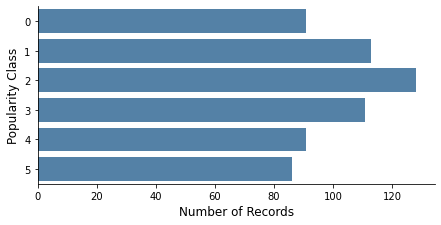

In [ ]:
# visualize class distribution
class_dist = sns.catplot(y="pop", kind="count", data=DF, orient='h', aspect=2, height=3, color = 'steelblue')
class_dist.set_xlabels('Number of Records', fontsize=12)
class_dist.set_ylabels('Popularity Class', fontsize=12)

## Data Preparation

In [ ]:
# EDA and Classification of Hit Song Rankings
# loading data
#import pandas as pd
#X_url = 'https://raw.githubusercontent.com/myseanwu/Hit-Song-Science/main/dataset_X.csv'
#y_url = 'https://raw.githubusercontent.com/myseanwu/Hit-Song-Science/main/dataset_y.csv'
#X = pd.read_csv(X_url, index_col=0)
#y = pd.read_csv(y_url, index_col=0)

y = DF['pop']
X = DF.drop(columns=['song','artist','rank','pop', 'url_avg', 'et_url_avg', 'hashtag_avg', 'et_hashtag_avg'])

## Exploratory Data Analysis

### Descriptive Statistics 

In [ ]:
X

,week,display_url_avg,avg_followers,avg_friends,avg_listed,sum_trunc,sum_http,avg_tokens,avg_char,avg_senti,avg_emoji_count,tweets_count,song_id,artist_id,url_avg_combined,hashtag_avg_combined
0,0,0.000000,2146.000000,2221.000000,1.000000,0.0,0.0,26.000000,138.000000,0.000000,0.000000,1.0,0,0,0.000000,0.000000
3,0,0.372093,1062.883721,932.953488,13.953488,9.0,23.0,21.255814,118.093023,0.290265,0.255814,43.0,1,1,0.046512,0.372093
5,0,0.000000,290.000000,264.500000,2.000000,0.0,0.0,19.000000,93.000000,0.469850,0.500000,2.0,2,2,0.000000,0.000000
6,0,0.032813,613.665625,615.884375,6.125000,13.0,27.0,19.764063,111.484375,0.362238,0.092188,640.0,3,3,0.009375,0.014063
7,0,1.000000,21621.166667,4436.333333,160.166667,2.0,5.0,17.833333,112.333333,0.225917,0.500000,6.0,4,4,0.500000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,12,0.000000,829.600000,875.400000,4.600000,0.0,0.0,22.000000,127.000000,0.630960,0.000000,5.0,151,81,0.000000,0.000000
3438,12,0.000000,11.000000,83.000000,0.000000,0.0,0.0,16.000000,93.000000,0.921900,6.000000,1.0,130,123,0.000000,1.000000
4781,12,0.066667,1046.233333,1196.900000,22.466667,1.0,2.0,19.666667,127.833333,0.361880,0.100000,30.0,152,124,0.066667,0.000000
4787,12,0.173913,1585.000000,1199.217391,4.043478,3.0,8.0,20.565217,104.869565,-0.137274,0.782609,23.0,122,125,0.173913,0.000000


### Check for Label Imbalance

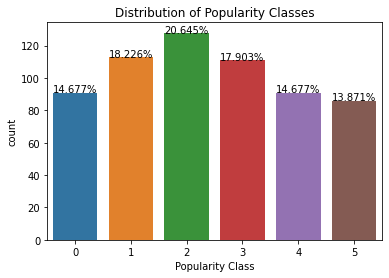

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
ax = sns.countplot(x="pop", data=DF)
plt.title('Distribution of Popularity Classes')
plt.xlabel('Popularity Class')
total = len(DF['pop'])
for p in ax.patches:
        percentage = '{:.3f}%'.format(100 * p.get_height()/total)
        x_coord = p.get_x() 
        y_coord = p.get_y() + p.get_height()+0.02
        ax.annotate(percentage, (x_coord, y_coord))

### Correlation Heatmap

Text(0.5, 1.0, 'Correlation Between Tweet Features')

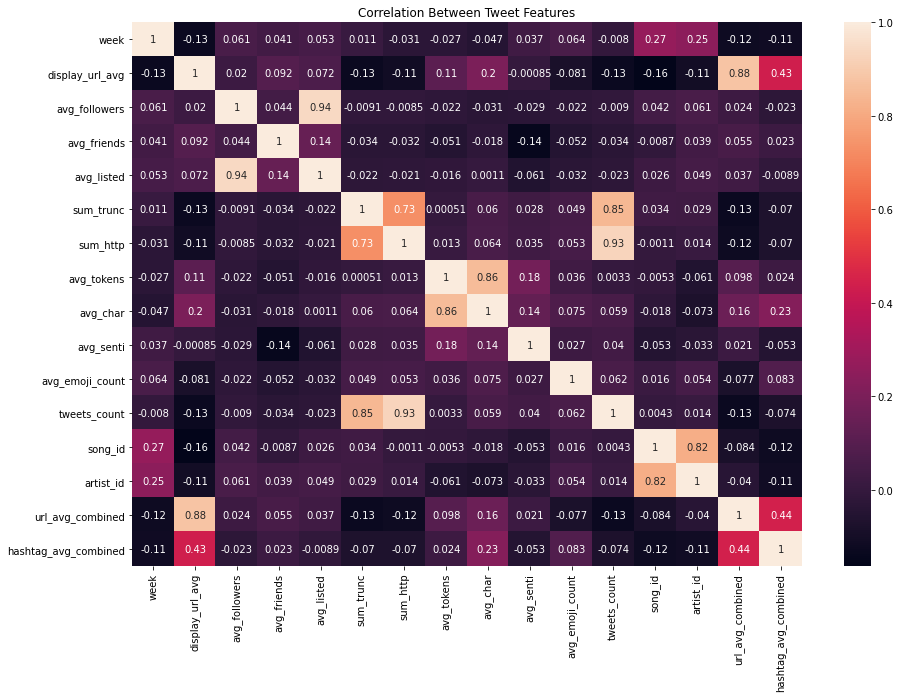

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(X.corr(),annot=True)
plt.title("Correlation Between Tweet Features")

### Chi-square Test fro Independence

In [ ]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
  

chi2_features = SelectKBest(chi2, k = 2)
X_kbest_features = chi2_features.fit_transform(X, y)
chi2_features


SelectKBest(k=2, score_func=<function chi2 at 0x7f61609f9830>)

### Principle component Analysis (PCA)

In [ ]:
import sklearn.decomposition as skd
pca_model = skd.PCA().fit(X)
principalComponents=pca_model.transform(X)
num_pc=["PC{}".format(i) for i in range(1,X.shape[1]+1)]
principalDf = pd.DataFrame(data = principalComponents, columns = num_pc)
principalDf

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,-4228.508910,-2273.152274,748.820222,-9.421858,-8.070648,-6.286690,-70.442557,-26.328428,-4.062367,4.180534,-3.414239,-0.333424,-0.173676,-0.780945,0.334966,0.104866
1,-5313.844017,-2221.568005,-537.014752,3.747731,0.000047,13.994201,-62.449612,-4.911506,-1.314418,4.320259,-1.823448,-0.315629,0.038265,-0.432963,0.004120,-0.132749
2,-6087.778293,-2263.943792,-1204.480445,-10.478262,-9.052803,5.728435,-62.434995,19.588949,2.342723,4.427994,-3.350411,0.692719,0.411103,-0.572339,-0.201166,0.046823
3,-5764.771851,-1635.430935,-849.736320,-115.050506,-2.095822,7.927765,-61.219010,1.610434,-0.852290,4.419391,-1.609900,-0.757716,-0.086410,-0.606981,-0.090302,0.071869
4,15250.572950,-2241.781167,2932.392211,-4.652014,-7.214329,93.378195,-32.500286,4.154828,1.029503,4.634929,-0.107373,-1.149521,0.268191,0.315317,-0.030754,-0.172350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,-5547.152657,-2263.652609,-594.468296,-10.885272,4.126939,-46.319950,95.589145,-20.229827,17.105097,-4.259366,-0.628448,-0.466018,-0.460242,-0.436654,-0.354112,0.012664
616,-6367.077180,-2264.367518,-1385.494890,-10.403361,3.893200,-48.661247,102.854969,21.540553,-23.323840,-4.149306,0.629811,0.918275,5.326378,0.059238,-0.652530,-0.028729
617,-5329.994353,-2240.299808,-273.070305,-13.937364,6.397227,-39.363046,124.539274,-14.696238,-16.966439,-3.829073,1.314678,-1.666457,-0.564648,-0.424691,-0.099185,0.053784
618,-4791.252788,-2244.839043,-271.792745,-6.659156,6.840499,-51.458329,95.621207,10.016248,-31.093808,-4.317125,-2.434707,1.037277,0.170892,-0.302096,0.450490,0.016713


#### How many PC(s) to keep?

In [ ]:
["PC{}".format(i) for i in range(1,X.shape[1]+1)]
eigen_prop_cum=pd.DataFrame(index=["Eigenvalue","Proportion of Variance Explained","Cumulative Proportion of Variance Explained"],columns=num_pc)
eigen_prop_cum.loc["Eigenvalue"]=pca_model.explained_variance_
eigen_prop_cum.loc["Proportion of Variance Explained"]=pca_model.explained_variance_ratio_
eigen_prop_cum.loc["Cumulative Proportion of Variance Explained"]=pca_model.explained_variance_ratio_.cumsum()
eigen_prop_cum

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
Eigenvalue,6.43197e+09,2.86481e+08,9.10037e+06,1.81118e+06,5237.88,3012.06,2627.51,424.023,239.004,13.2553,4.39901,1.9084,0.851091,0.298661,0.0770274,0.0246493
Proportion of Variance Explained,0.955805,0.0425717,0.00135234,0.000269145,7.78362e-07,4.476e-07,3.90454e-07,6.30109e-08,3.55165e-08,1.96977e-09,6.53703e-10,2.83593e-10,1.26474e-10,4.43817e-11,1.14465e-11,3.66294e-12
Cumulative Proportion of Variance Explained,0.955805,0.998377,0.999729,0.999998,0.999999,1,1,1,1,1,1,1,1,1,1,1


#### Screeplot

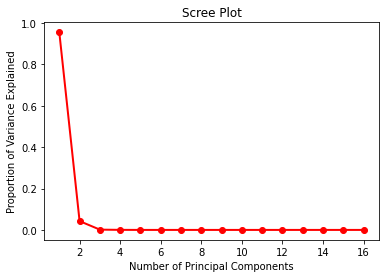

In [ ]:
PC_values = np.arange(pca_model.n_components_) + 1
plt.plot(PC_values, pca_model.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.show()

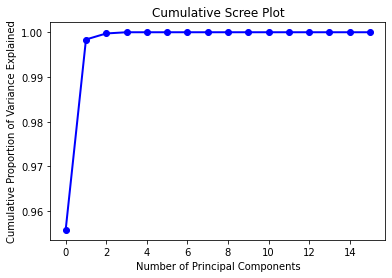

In [ ]:
plt.plot(np.cumsum(pca_model.explained_variance_ratio_), 'bo-', linewidth=2)
plt.title('Cumulative Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained');

#### Factor Loadings

Text(0.5, 1.0, 'Original Variables vs First 2 Principal Components (with Heatmap)')

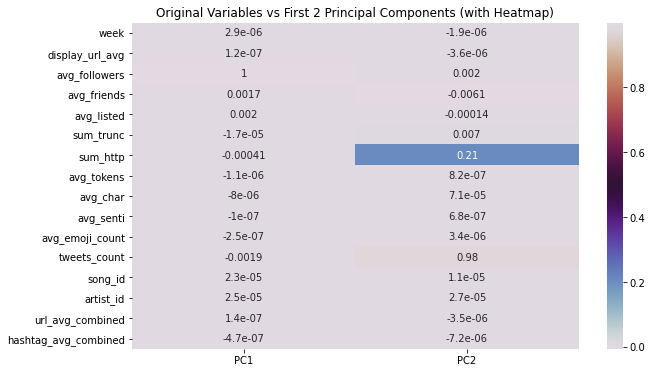

In [ ]:
loadings = pd.DataFrame(pca_model.components_.T, columns=num_pc, index=X.columns)
plt.figure(figsize=(10,6))
sns.heatmap(loadings.iloc[:,:2], annot=True,cmap='twilight')
plt.title("Original Variables vs First 2 Principal Components (with Heatmap)")

### Exploratory Factor Analysis (EFA)




                  Factor1   Factor2   Factor3   Factor4   Factor5   Factor6
week            -0.039175  0.059094 -0.020912  0.232106  0.061466  0.343367
display_url_avg -0.105049  0.038985  0.160322 -0.094253  0.067502 -0.352463
avg_followers   -0.003755  0.949478 -0.025453  0.032692 -0.007748  0.009729
avg_friends     -0.013925  0.052702 -0.038680  0.015314  0.991534 -0.085040
avg_listed      -0.010180  0.991215 -0.007097  0.029473  0.087384 -0.070841
sum_trunc        0.815880 -0.006465  0.017303  0.014716 -0.011907  0.110296
sum_http         0.906280 -0.006337  0.022508 -0.007634 -0.015222  0.046749
avg_tokens      -0.012642 -0.004252  0.868011 -0.012026 -0.019673  0.024203
avg_char         0.054749 -0.001522  0.992315 -0.002463  0.017127 -0.093307
avg_senti        0.019096 -0.031064  0.172312 -0.059800 -0.121437  0.128185
avg_emoji_count  0.042274 -0.018781  0.064524  0.011128 -0.028491  0.195426
tweets_count     1.004964 -0.004970  0.015032 -0.010411 -0.010900  0.090658
song_id     

Text(0.5, 1.0, 'Clustermap Original Variables vs 6 Latent Factors')

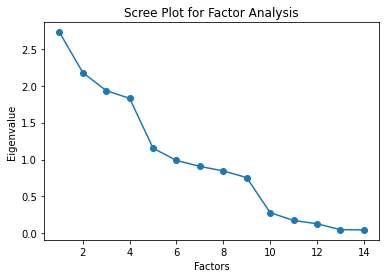

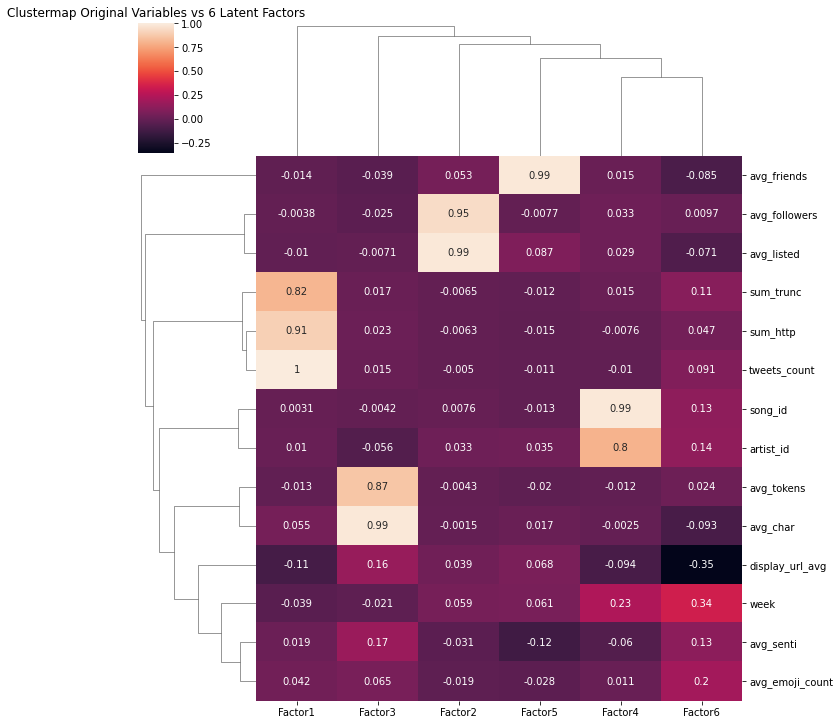

In [ ]:
!pip install factor-analyzer
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(10, rotation='varimax')
fa.fit(X)

eigen_values, vectors = fa.get_eigenvalues()
plt.scatter(range(1,X.shape[1]+1),eigen_values)
plt.plot(range(1,X.shape[1]+1),eigen_values)
plt.title("Scree Plot for Factor Analysis")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")

fa = FactorAnalyzer(6, rotation='varimax')
fa.fit(X)
loads = fa.loadings_
loadsdf = pd.DataFrame(loads, columns=["Factor1","Factor2","Factor3","Factor4","Factor5", "Factor6" ],index=X.columns)
print(loadsdf)
sns.clustermap(loadsdf, annot=True)
plt.title("Clustermap Original Variables vs 6 Latent Factors")






## Model Fitting 

In [ ]:
# dataset
# split 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# poly = PolynomialFeatures(2) #
# X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_trans = scaler.fit_transform(X_train)
X_test_trans = scaler.transform(X_test)

#### Feature Importance

In [ ]:
# Feauture Importance - RF
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# define the model
rf_model = RandomForestRegressor(random_state=0)
# fit the model
rf_model.fit(X_train, y_train)
# get importance
importance = rf_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.02621
Feature: 1, Score: 0.01294
Feature: 2, Score: 0.02592
Feature: 3, Score: 0.02425
Feature: 4, Score: 0.01724
Feature: 5, Score: 0.02716
Feature: 6, Score: 0.02352
Feature: 7, Score: 0.01704
Feature: 8, Score: 0.01939
Feature: 9, Score: 0.02447
Feature: 10, Score: 0.01361
Feature: 11, Score: 0.03080
Feature: 12, Score: 0.62776
Feature: 13, Score: 0.07790
Feature: 14, Score: 0.01232
Feature: 15, Score: 0.01946


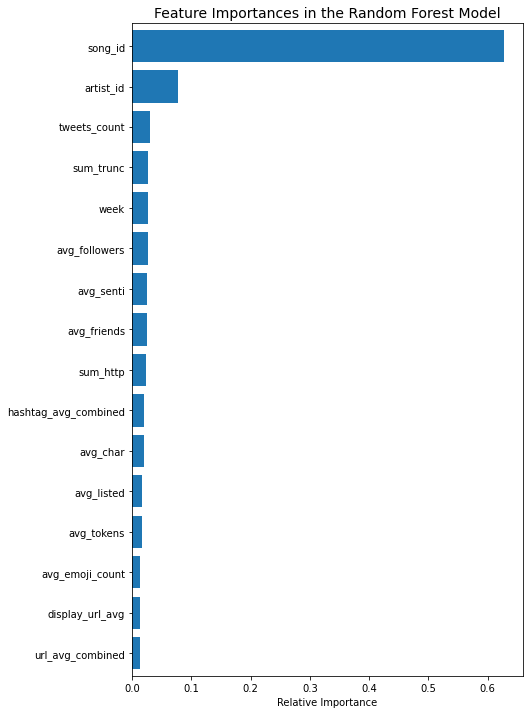

In [ ]:
features = X_train.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(7,12))
plt.title('Feature Importances in the Random Forest Model', fontsize=14)
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.margins(y=0.01)
plt.show()

In [ ]:
# LR Feature Importance
from sklearn.linear_model import LinearRegression

# define the model
model = LinearRegression()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))


Feature: 0, Score: 0.03207
Feature: 1, Score: -0.00251
Feature: 2, Score: -0.00000
Feature: 3, Score: -0.00001
Feature: 4, Score: 0.00235
Feature: 5, Score: -0.00034
Feature: 6, Score: -0.00001
Feature: 7, Score: 0.03245
Feature: 8, Score: -0.01529
Feature: 9, Score: 0.06959
Feature: 10, Score: 0.18948
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.01548
Feature: 13, Score: 0.01136
Feature: 14, Score: 1.04254
Feature: 15, Score: -0.05053


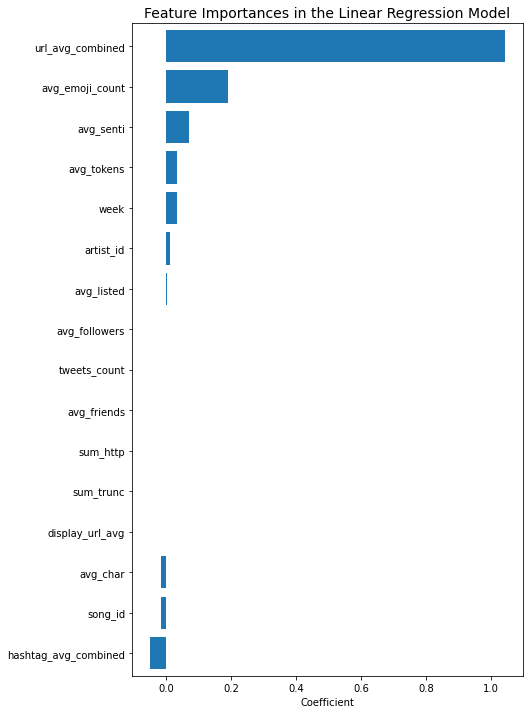

In [ ]:
features = X_train.columns
importances = model.coef_
indices = np.argsort(importances)

plt.figure(figsize=(7,12))
plt.title('Feature Importances in the Linear Regression Model', fontsize=14)
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Coefficient')
plt.margins(y=0.01)
plt.show()

# viz reference: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import operator
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.ensemble import ExtraTreesClassifier

### SVC

In [ ]:
# SVC CV
# with scaled data - minmax
from sklearn.svm import SVC
import operator

scores = {}
for this_kernel in ['linear', 'rbf']:
    for this_gamma in [0.1, 0.5, 1, 5, 10]:
        for this_C in [0.1, 0.5, 1, 5, 10]:
            clf = SVC(kernel=this_kernel, gamma=this_gamma, C=this_C)
            scores[(this_kernel, this_gamma, this_C)] = np.mean(cross_val_score(clf, X_train_trans, y_train, cv=5))

best_kernel, best_gamma, best_C = max(scores.items(), key=operator.itemgetter(1))[0]
clf = SVC(kernel=best_kernel, gamma=best_gamma, C=best_C).fit(X_train_trans, y_train)
test_score = clf.score(X_test_trans, y_test)


best_kernel, best_C, best_gamma, test_score

('rbf', 10, 0.5, 0.49193548387096775)

In [ ]:
# SVC after CV
# with scaled data - minmax
svc = SVC(random_state=0, tol=1e-5, max_iter=200000,kernel=best_kernel ,gamma=best_gamma, C=best_C )
svc.fit(X_train_trans, y_train)

y_pred_train = svc.predict(X_train_trans)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
svc_pred = svc.predict(X_test_trans)
b = mean_absolute_error(y_test, svc_pred)
print(b)

# score
print("Training Score:", svc.score(X_train_trans, y_train))
print("Testing Score:", svc.score(X_test_trans, y_test))
print(classification_report(y_test, svc_pred))

from sklearn.metrics import f1_score
from scipy.stats import skew, kurtosis

# SVC error table 
svc_error_table=pd.DataFrame({'Model':['SVC (With scaler) - Baseline'], 
                              'train error':[a],'test error':[b], 
                              "train score":[svc.score(X_train_trans, y_train)], 
                              "test score":[svc.score(X_test_trans, y_test)], 
                              "F1-Score":[f1_score(y_test, svc_pred, average='macro')], 
                              "Skewness":[skew(svc_pred)],
                              "Kurtosis":[kurtosis(svc_pred)]})
svc_error_table

train mae: 
0.6391129032258065
test mae: 
0.7419354838709677
Training Score: 0.6048387096774194
Testing Score: 0.49193548387096775
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.47      0.63      0.54        27
           2       0.42      0.39      0.41        33
           3       0.50      0.27      0.35        22
           4       0.25      0.31      0.28        13
           5       0.43      0.46      0.44        13

    accuracy                           0.49       124
   macro avg       0.51      0.50      0.50       124
weighted avg       0.50      0.49      0.49       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,SVC (With scaler) - Baseline,0.639113,0.741935,0.604839,0.491935,0.49782,0.481523,-0.872659


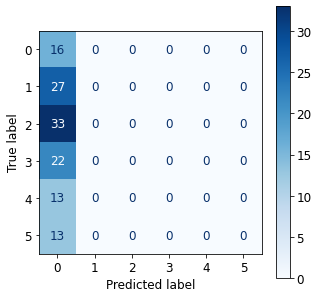

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(svc, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

In [ ]:
# default
# without scaler

from sklearn.svm import SVC

svc2 = SVC(random_state=0, tol=1e-5, max_iter=200000)
svc2.fit(X_train, y_train)

svc_y_pred_train = svc2.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,svc_y_pred_train)
print(a)

print('test mae: ')
svc_pred2 = svc2.predict(X_test)
b = mean_absolute_error(y_test, svc_pred2)
print(b)

# score
print("Training Score:", svc2.score(X_train, y_train))
print("Testing Score:", svc2.score(X_test, y_test))
print(classification_report(y_test, svc_pred2))

# SVC error table 
svc_error_table2 = pd.DataFrame({'Model':['SVC (Without scaler)'], 
                              'train error':[a],'test error':[b], 
                              "train score":[svc2.score(X_train, y_train)], 
                              "test score":[svc2.score(X_test, y_test)], 
                              "F1-Score":[f1_score(y_test, svc_pred2, average='macro')], 
                              "Skewness":[skew(svc_pred2)],
                              "Kurtosis":[kurtosis(svc_pred2)]})
svc_error_table2

train mae: 
1.3830645161290323
test mae: 
1.1612903225806452
Training Score: 0.21370967741935484
Testing Score: 0.28225806451612906
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       1.00      0.07      0.14        27
           2       0.27      1.00      0.43        33
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        13

    accuracy                           0.28       124
   macro avg       0.21      0.18      0.09       124
weighted avg       0.29      0.28      0.14       124



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,SVC (Without scaler),1.383065,1.16129,0.21371,0.282258,0.093956,-7.682213,57.016393


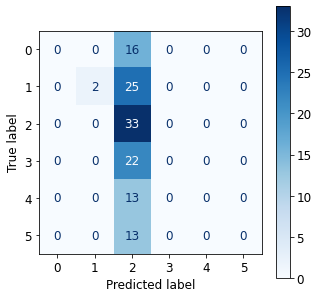

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(svc2, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

#### Feature Selection

In [ ]:
# With Feature Selection - ExtraTrees
from sklearn.svm import SVC

svc_clf = svc2 = SVC(random_state=0, tol=1e-5, max_iter=200000)
scaler = MinMaxScaler()
selector = SelectFromModel(ExtraTreesClassifier(n_estimators=50,random_state=0))

svc_pipe = Pipeline([('scaler',scaler), ('selector', selector), ('clf', svc_clf)])

svc_pipe.fit(X_train, y_train)
svc_pred3 = svc_pipe.predict(X_test)

svc_pred_train = svc_pipe.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,svc_pred_train)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, svc_pred3)
print(b)

# score
print("Training Score:", svc_pipe.score(X_train, y_train))
print("Testing Score:", svc_pipe.score(X_test, y_test))
print(classification_report(y_test, svc_pred3))

# Obtain F1-score
svc_f1_score=f1_score(y_test, svc_pred3, average='macro')
## examining sample skewness
svc_test_skew=skew(svc_pred3)
# Random Forest error table 
svc_error_table3 = pd.DataFrame({'Model':['SVC (ExtraTrees)'], 
                              'train error':[a],'test error':[b], 
                              "train score":[svc_pipe.score(X_train, y_train)], 
                              "test score":[svc_pipe.score(X_test, y_test)], 
                              "F1-Score":[f1_score(y_test, svc_pred3, average='macro')], 
                              "Skewness":[skew(svc_pred3)],
                              "Kurtosis":[kurtosis(svc_pred3)]})
svc_error_table3

train mae: 
0.8326612903225806
test mae: 
0.8467741935483871
Training Score: 0.5100806451612904
Testing Score: 0.5241935483870968
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.46      0.70      0.56        27
           2       0.55      0.36      0.44        33
           3       0.44      0.32      0.37        22
           4       0.20      0.08      0.11        13
           5       0.42      0.77      0.54        13

    accuracy                           0.52       124
   macro avg       0.51      0.54      0.50       124
weighted avg       0.52      0.52      0.50       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,SVC (ExtraTrees),0.832661,0.846774,0.510081,0.524194,0.502543,0.541525,-1.005999


### MLP

In [ ]:
# MLP
# with scaled data - minmax
from sklearn.neural_network import MLPClassifier
                                                   
mlp = MLPClassifier(random_state=0, max_iter=10000).fit(X_train_trans, y_train)
y_pred_train=mlp.predict(X_train_trans)

print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
mlp_prediction = mlp.predict(X_test_trans)
b = mean_absolute_error(y_test, mlp_prediction)
print(b)

# score
print("Training Score:", mlp.score(X_train_trans, y_train))
print("Testing Score:", mlp.score(X_test_trans, y_test))
print(classification_report(y_test, mlp_prediction))

# Obtain F1-score
mlp_f1_score=f1_score(y_test, mlp_prediction, average='macro')
## examining sample skewness
mlp_test_skew=skew(mlp_prediction)
# MLP error table 
mlp_error_table = pd.DataFrame({'Model':['MLP (With scaler)'], 
                              'train error':[a],'test error':[b], 
                              "train score":[mlp.score(X_train_trans, y_train)], 
                              "test score":[mlp.score(X_test_trans, y_test)], 
                              "F1-Score":[f1_score(y_test, mlp_prediction, average='macro')], 
                              "Skewness":[skew(mlp_prediction)],
                              "Kurtosis":[kurtosis(mlp_prediction)]})
mlp_error_table

train mae: 
0.3346774193548387
test mae: 
0.7096774193548387
Training Score: 0.7782258064516129
Testing Score: 0.5080645161290323
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.48      0.59      0.53        27
           2       0.41      0.42      0.42        33
           3       0.41      0.41      0.41        22
           4       0.43      0.23      0.30        13
           5       0.46      0.46      0.46        13

    accuracy                           0.51       124
   macro avg       0.53      0.51      0.51       124
weighted avg       0.51      0.51      0.50       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,MLP (With scaler),0.334677,0.709677,0.778226,0.508065,0.514936,0.536788,-0.468568


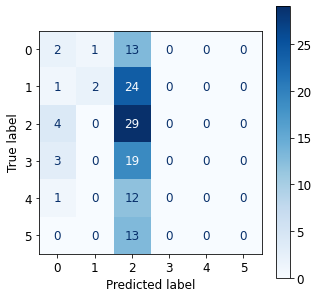

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(mlp, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

In [ ]:
# without scaler
from sklearn.neural_network import MLPClassifier
                                                   
mlp2 = MLPClassifier(random_state=0, max_iter=10000).fit(X_train, y_train)
y_pred_train=mlp.predict(X_train)

print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
mlp_pred0 = mlp.predict(X_test)
b = mean_absolute_error(y_test, mlp_pred0)
print(b)

# score
print("Training Score:", mlp2.score(X_train, y_train))
print("Testing Score:", mlp2.score(X_test, y_test))
print(classification_report(y_test, mlp_pred0))

# MLP error table 
mlp_error_table2 = pd.DataFrame({'Model':['MLP (Without scaler)'], 
                              'train error':[a],'test error':[b], 
                              "train score":[mlp2.score(X_train, y_train)], 
                              "test score":[mlp2.score(X_test, y_test)], 
                              "F1-Score":[f1_score(y_test, mlp_pred0, average='macro')], 
                              "Skewness":[skew(mlp_pred0)],
                              "Kurtosis":[kurtosis(mlp_pred0)]})
mlp_error_table2


train mae: 
1.497983870967742
test mae: 
1.25
Training Score: 0.3971774193548387
Testing Score: 0.4112903225806452
              precision    recall  f1-score   support

           0       0.18      0.12      0.15        16
           1       0.67      0.07      0.13        27
           2       0.26      0.88      0.41        33
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        13

    accuracy                           0.27       124
   macro avg       0.19      0.18      0.11       124
weighted avg       0.24      0.27      0.16       124



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,MLP (Without scaler),1.497984,1.25,0.397177,0.41129,0.114513,-2.646845,5.202339


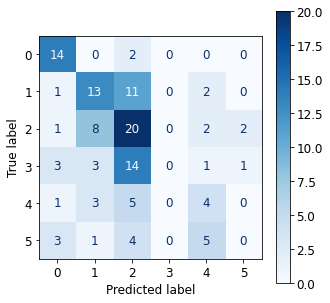

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(mlp2, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

#### Feature Selection

In [ ]:
# MLP
# with scaled data - minmax
# with feature selection - selectpercentile
from sklearn.neural_network import MLPClassifier
                                                   
mlp = MLPClassifier(random_state=0, max_iter=10000)
scaler = MinMaxScaler()
selector = SelectPercentile(chi2)

mlp_pipe = Pipeline([('scaler',scaler), ('selector', selector), ('clf', mlp)])

mlp_pipe.fit(X_train, y_train)
mlp_pred = mlp_pipe.predict(X_test)

mlp_pred_train = mlp_pipe.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,mlp_pred_train)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, mlp_pred)
print(b)

# score
print("Training Score:", mlp_pipe.score(X_train, y_train))
print("Testing Score:", mlp_pipe.score(X_test, y_test))
print(classification_report(y_test, mlp_pred))

# Obtain F1-score
mlp_f1_score=f1_score(y_test, mlp_pred, average='macro')
## examining sample skewness
mlp_test_skew=skew(mlp_pred)
# mlp error table 
mlp_error_table3 =pd.DataFrame({'Model':['MLP (SelectPercentile)'], 
                              'train error':[a],'test error':[b], 
                              "train score":[mlp_pipe.score(X_train, y_train)], 
                              "test score":[mlp_pipe.score(X_test, y_test)], 
                              "F1-Score":[f1_score(y_test, mlp_pred, average='macro')], 
                              "Skewness":[skew(mlp_pred)],
                              "Kurtosis":[kurtosis(mlp_pred)]})
mlp_error_table3

train mae: 
0.9213709677419355
test mae: 
0.9274193548387096
Training Score: 0.49193548387096775
Testing Score: 0.45161290322580644
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       0.53      0.63      0.58        27
           2       0.50      0.09      0.15        33
           3       0.32      0.50      0.39        22
           4       0.14      0.08      0.10        13
           5       0.30      0.62      0.40        13

    accuracy                           0.45       124
   macro avg       0.45      0.49      0.43       124
weighted avg       0.47      0.45      0.41       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,MLP (SelectPercentile),0.921371,0.927419,0.491935,0.451613,0.427358,0.104017,-1.308083


In [ ]:
# MLP
# with scaled data - minmax
# with feature selection - ExtraTrees

from sklearn.neural_network import MLPClassifier
                                                   
mlp = MLPClassifier(random_state=0, max_iter=10000)
scaler = MinMaxScaler()
selector = SelectFromModel(ExtraTreesClassifier(n_estimators=50,random_state=0))

mlp_pipe2 = Pipeline([('scaler',scaler), ('selector', selector), ('clf', mlp)])

mlp_pipe2.fit(X_train, y_train)
mlp_pred2= mlp_pipe2.predict(X_test)

mlp_pred_train2 = mlp_pipe2.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,mlp_pred_train2)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, mlp_pred2)
print(b)

# score
print("Training Score:", mlp_pipe2.score(X_train, y_train))
print("Testing Score:", mlp_pipe2.score(X_test, y_test))
print(classification_report(y_test, mlp_pred2))

# Obtain F1-score
mlp_f1_score=f1_score(y_test, mlp_pred2, average='macro')
## examining sample skewness
mlp_test_skew=skew(mlp_pred2)
# mlp error table 
mlp_error_table4 =pd.DataFrame({'Model':['MLP (ExtraTrees)'], 
                              'train error':[a],'test error':[b], 
                              "train score":[mlp_pipe2.score(X_train, y_train)], 
                              "test score":[mlp_pipe2.score(X_test, y_test)], 
                              "F1-Score":[f1_score(y_test, mlp_pred2, average='macro')], 
                              "Skewness":[skew(mlp_pred2)],
                              "Kurtosis":[kurtosis(mlp_pred2)]})
mlp_error_table4

train mae: 
0.7076612903225806
test mae: 
0.7580645161290323
Training Score: 0.5564516129032258
Testing Score: 0.532258064516129
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.55      0.63      0.59        27
           2       0.56      0.42      0.48        33
           3       0.38      0.41      0.39        22
           4       0.00      0.00      0.00        13
           5       0.43      0.77      0.56        13

    accuracy                           0.53       124
   macro avg       0.49      0.54      0.50       124
weighted avg       0.51      0.53      0.51       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,MLP (ExtraTrees),0.707661,0.758065,0.556452,0.532258,0.502638,0.365399,-1.002553


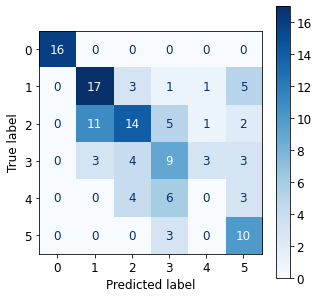

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(mlp_pipe2, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

#### Feature Expansion

In [ ]:
# with feature expansion
mlp = MLPClassifier(random_state=0, max_iter=10000)
scaler = MinMaxScaler()
trans = PolynomialFeatures(2)

mlp_pipe3 = Pipeline([('scaler',scaler), ('expansion', trans), ('clf', mlp)])

mlp_pipe3.fit(X_train, y_train)
mlp_pred3= mlp_pipe3.predict(X_test)

mlp_pred_train3 = mlp_pipe3.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,mlp_pred_train3)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, mlp_pred3)
print(b)

# score
print("Training Score:", mlp_pipe3.score(X_train, y_train))
print("Testing Score:", mlp_pipe3.score(X_test, y_test))
print(classification_report(y_test, mlp_pred3))

# Obtain F1-score
mlp_f1_score=f1_score(y_test, mlp_pred3, average='macro')
## examining sample skewness
mlp_test_skew=skew(mlp_pred3)
# Random Forest error table 
mlp_error_table5 =pd.DataFrame({'Model':['MLP (Expansion2)'], 
                              'train error':[a],'test error':[b], 
                              "train score":[mlp_pipe3.score(X_train, y_train)], 
                              "test score":[mlp_pipe3.score(X_test, y_test)], 
                              "F1-Score":[f1_score(y_test, mlp_pred3, average='macro')], 
                              "Skewness":[skew(mlp_pred3)],
                              "Kurtosis":[kurtosis(mlp_pred3)]})
mlp_error_table5

train mae: 
0.034274193548387094
test mae: 
0.6935483870967742
Training Score: 0.9778225806451613
Testing Score: 0.5161290322580645
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.54      0.74      0.62        27
           2       0.42      0.30      0.35        33
           3       0.47      0.41      0.44        22
           4       0.23      0.23      0.23        13
           5       0.43      0.46      0.44        13

    accuracy                           0.52       124
   macro avg       0.51      0.52      0.51       124
weighted avg       0.50      0.52      0.50       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,MLP (Expansion2),0.034274,0.693548,0.977823,0.516129,0.509969,0.453676,-0.890025


In [ ]:
# feature selection + feature expansion
# best performing model
mlp = MLPClassifier(random_state=0, max_iter=10000)
scaler = MinMaxScaler()
trans = PolynomialFeatures(2)
selector = SelectFromModel(ExtraTreesClassifier(n_estimators=50,random_state=0))

mlp_pipe4 = Pipeline([('scaler',scaler), ('expansion', trans), ('selector', selector), ('clf', mlp)])

mlp_pipe4.fit(X_train, y_train)
mlp_pred4= mlp_pipe4.predict(X_test)

mlp_pred_train4 = mlp_pipe4.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,mlp_pred_train4)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, mlp_pred4)
print(b)

# score
print("Training Score:", mlp_pipe4.score(X_train, y_train))
print("Testing Score:", mlp_pipe4.score(X_test, y_test))
print(classification_report(y_test, mlp_pred4))

# Obtain F1-score
mlp_f1_score=f1_score(y_test, mlp_pred4, average='macro')
## examining sample skewness
mlp_test_skew=skew(mlp_pred4)
# Random Forest error table 
mlp_error_table6 =pd.DataFrame({'Model':['MLP (ExtraTrees + Expansion2)'], 
                              'train error':[a],'test error':[b], 
                              "train score":[mlp_pipe4.score(X_train, y_train)], 
                              "test score":[mlp_pipe4.score(X_test, y_test)], 
                              "F1-Score":[f1_score(y_test, mlp_pred4, average='macro')], 
                              "Skewness":[skew(mlp_pred4)],
                              "Kurtosis":[kurtosis(mlp_pred4)]})
mlp_error_table6

train mae: 
0.36088709677419356
test mae: 
0.6612903225806451
Training Score: 0.7419354838709677
Testing Score: 0.5725806451612904
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.63      0.63      0.63        27
           2       0.57      0.64      0.60        33
           3       0.46      0.27      0.34        22
           4       0.29      0.38      0.33        13
           5       0.43      0.46      0.44        13

    accuracy                           0.57       124
   macro avg       0.56      0.56      0.56       124
weighted avg       0.57      0.57      0.57       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,MLP (ExtraTrees + Expansion2),0.360887,0.66129,0.741935,0.572581,0.558377,0.357644,-0.879741


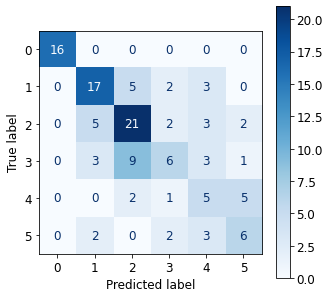

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(mlp_pipe4, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

### Random Forest

In [ ]:
# RandomForest
# with scaled data - minmax
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0,max_depth=25, n_estimators=100,min_samples_leaf=1).fit(X_train_trans, y_train)

y_pred_train = rf.predict(X_train_trans)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
rf_prediction = rf.predict(X_test_trans)
b = mean_absolute_error(y_test, rf_prediction)
print(b)
# print(prediction)
# score
print("Training Score:", rf.score(X_train_trans, y_train))
print("Testing Score:", rf.score(X_test_trans, y_test))
print(classification_report(y_test, rf_prediction))

# Random Forest error table 
rf_error_table=pd.DataFrame({'Model':['Random Forest (With Scaler)'], 
                             'train error':[a],'test error':[b], 
                             "train score":[rf.score(X_train, y_train)], 
                             "test score":[rf.score(X_test, y_test)], 
                             "F1-Score":[f1_score(y_test, rf_prediction, average='macro')], 
                             "Skewness":[skew(rf_prediction)],
                              "Kurtosis":[kurtosis(rf_prediction)]})
rf_error_table



train mae: 
0.0
test mae: 
0.5725806451612904
Training Score: 1.0
Testing Score: 0.5806451612903226
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.68      0.85      0.75        27
           2       0.57      0.48      0.52        33
           3       0.38      0.36      0.37        22
           4       0.31      0.31      0.31        13
           5       0.42      0.38      0.40        13

    accuracy                           0.58       124
   macro avg       0.56      0.57      0.56       124
weighted avg       0.57      0.58      0.57       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Random Forest (With Scaler),0.0,0.572581,0.163306,0.129032,0.559746,0.418347,-0.788867


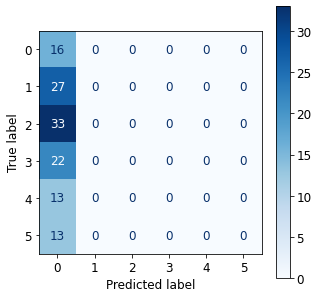

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

#### Feature Selection

In [ ]:
# with feature selection - SelectPercentile
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=0,max_depth=25, n_estimators=100,min_samples_leaf=1)
scaler = MinMaxScaler()
selector = SelectPercentile(chi2)

rf_pipe = Pipeline([('scaler',scaler), ('selector', selector), ('clf', rf_clf)])

rf_pipe.fit(X_train, y_train)
rf_pred = rf_pipe.predict(X_test)

y_pred_train = rf_pipe.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, rf_pred)
print(b)

# score
print("Training Score:", rf_pipe.score(X_train, y_train))
print("Testing Score:", rf_pipe.score(X_test, y_test))
print(classification_report(y_test, rf_pred))

# Random Forest error table 
rf_error_table2=pd.DataFrame({'Model':['Random Forest (SelectPercentile)'], 
                             'train error':[a],'test error':[b], 
                             "train score":[rf_pipe.score(X_train, y_train)], 
                             "test score":[rf_pipe.score(X_test, y_test)], 
                             "F1-Score":[f1_score(y_test, rf_pred, average='macro')], 
                             "Skewness":[skew(rf_pred)],
                              "Kurtosis":[kurtosis(rf_pred)]})
rf_error_table2

train mae: 
0.3185483870967742
test mae: 
0.4435483870967742
Training Score: 0.7419354838709677
Testing Score: 0.6532258064516129
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.77      0.74      0.75        27
           2       0.59      0.52      0.55        33
           3       0.57      0.55      0.56        22
           4       0.39      0.54      0.45        13
           5       0.64      0.69      0.67        13

    accuracy                           0.65       124
   macro avg       0.66      0.67      0.66       124
weighted avg       0.66      0.65      0.66       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Random Forest (SelectPercentile),0.318548,0.443548,0.741935,0.653226,0.663254,0.200546,-0.998711


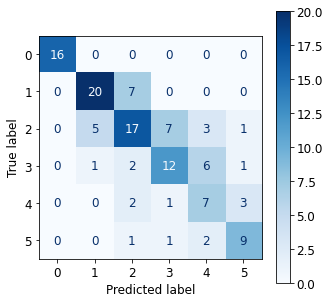

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(rf_pipe, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

In [ ]:
# with feature selection - ExtraTrees
# best performing model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

rf_clf = RandomForestClassifier(random_state=0,max_depth=25, n_estimators=100,min_samples_leaf=1)
scaler = MinMaxScaler()
selector = SelectFromModel(ExtraTreesClassifier(n_estimators=50, random_state=0))

rf_pipe2 = Pipeline([('scaler',scaler), ('selector', selector), ('clf', rf_clf)])

rf_pipe2.fit(X_train, y_train)
rf_pred2 = rf_pipe2.predict(X_test)

y_pred_train2 = rf_pipe2.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train2)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, rf_pred2)
print(b)

# score
print("Training Score:", rf_pipe2.score(X_train, y_train))
print("Testing Score:", rf_pipe2.score(X_test, y_test))
print(classification_report(y_test, rf_pred2))

# Obtain F1-score
rf_f1_score=f1_score(y_test, rf_pred2, average='macro')
## examining sample skewness
rf_test_skew=skew(rf_pred2)
# Random Forest error table 
rf_error_table3 =pd.DataFrame({'Model':['Random Forest (ExtraTrees)'], 
                             'train error':[a],'test error':[b], 
                             "train score":[rf_pipe2.score(X_train, y_train)], 
                             "test score":[rf_pipe2.score(X_test, y_test)], 
                             "F1-Score":[f1_score(y_test, rf_pred2, average='macro')], 
                             "Skewness":[skew(rf_pred2)],
                             "Kurtosis":[kurtosis(rf_pred2)]})
rf_error_table3

train mae: 
0.0
test mae: 
0.3870967741935484
Training Score: 1.0
Testing Score: 0.75
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.88      0.81      0.85        27
           2       0.76      0.85      0.80        33
           3       0.72      0.59      0.65        22
           4       0.56      0.38      0.45        13
           5       0.47      0.69      0.56        13

    accuracy                           0.75       124
   macro avg       0.73      0.72      0.72       124
weighted avg       0.76      0.75      0.75       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Random Forest (ExtraTrees),0.0,0.387097,1.0,0.75,0.718867,0.384444,-0.825835


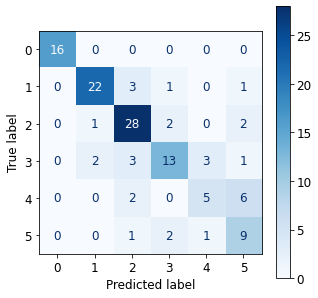

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(rf_pipe2, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

In [ ]:
# with feature selection -LR
rf_clf = RandomForestClassifier(random_state=0,max_depth=25, n_estimators=100,min_samples_leaf=1)
scaler = MinMaxScaler()
selector = SelectFromModel(LinearRegression())

rf_pipe3 = Pipeline([('scaler',scaler), ('selector', selector), ('clf', rf_clf)])

rf_pipe3.fit(X_train, y_train)
rf_pred3 = rf_pipe3.predict(X_test)

y_pred_train3 = rf_pipe3.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train3)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, rf_pred3)
print(b)

# score
print("Training Score:", rf_pipe3.score(X_train, y_train))
print("Testing Score:", rf_pipe3.score(X_test, y_test))
print(classification_report(y_test, rf_pred3))

# Random Forest error table 
rf_error_table4=pd.DataFrame({'Model':['Random Forest (LR)'], 
                             'train error':[a],'test error':[b], 
                             "train score":[rf_pipe3.score(X_train, y_train)], 
                             "test score":[rf_pipe3.score(X_test, y_test)], 
                             "F1-Score":[f1_score(y_test, rf_pred3, average='macro')], 
                             "Skewness":[skew(rf_pred3)],
                             "Kurtosis":[kurtosis(rf_pred3)]})
rf_error_table4

train mae: 
0.0020161290322580645
test mae: 
0.7338709677419355
Training Score: 0.9979838709677419
Testing Score: 0.5161290322580645
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.71      0.74      0.73        27
           2       0.52      0.39      0.45        33
           3       0.33      0.36      0.35        22
           4       0.12      0.15      0.14        13
           5       0.33      0.38      0.36        13

    accuracy                           0.52       124
   macro avg       0.50      0.51      0.50       124
weighted avg       0.53      0.52      0.52       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Random Forest (LR),0.002016,0.733871,0.997984,0.516129,0.503075,0.207457,-1.020184


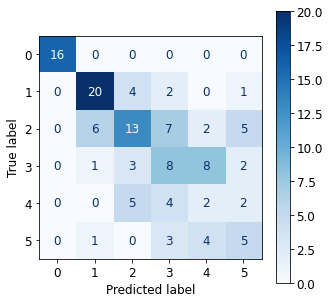

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(rf_pipe3, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

#### Feature Expansion

In [ ]:
# with feature expansion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import f1_score
from scipy.stats import skew 

rf_clf = RandomForestClassifier(random_state=0,max_depth=25, n_estimators=100,min_samples_leaf=1)
scaler = MinMaxScaler()
trans = PolynomialFeatures(degree=2)

rf_pipe4 = Pipeline([('scaler',scaler), ('expansion', trans), ('clf', rf_clf)])

rf_pipe4.fit(X_train, y_train)
rf_pred4 = rf_pipe4.predict(X_test)

y_pred_train4 = rf_pipe4.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train4)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, rf_pred4)
print(b)

# score
print("Training Score:", rf_pipe4.score(X_train, y_train))
print("Testing Score:", rf_pipe4.score(X_test, y_test))
print(classification_report(y_test, rf_pred4))

# Obtain F1-score
rf_f1_score=f1_score(y_test, rf_pred4, average='macro')
## examining sample skewness
rf_test_skew=skew(rf_pred4)
# Random Forest error table 
rf_error_table5=pd.DataFrame({'Model':['Random Forest (Expansion2)'], 
                             'train error':[a],'test error':[b], 
                             "train score":[rf_pipe4.score(X_train, y_train)], 
                             "test score":[rf_pipe4.score(X_test, y_test)], 
                             "F1-Score":[f1_score(y_test, rf_pred4, average='macro')], 
                             "Skewness":[skew(rf_pred4)],
                             "Kurtosis":[kurtosis(rf_pred4)]})
rf_error_table5

train mae: 
0.0
test mae: 
0.5161290322580645
Training Score: 1.0
Testing Score: 0.6048387096774194
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.67      0.74      0.70        27
           2       0.69      0.55      0.61        33
           3       0.39      0.41      0.40        22
           4       0.31      0.38      0.34        13
           5       0.54      0.54      0.54        13

    accuracy                           0.60       124
   macro avg       0.60      0.60      0.60       124
weighted avg       0.62      0.60      0.61       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Random Forest (Expansion2),0.0,0.516129,1.0,0.604839,0.599202,0.265415,-0.961167


In [ ]:
# with feature expansion + feature selection(Extratrees)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from scipy.stats import skew 

rf_clf = RandomForestClassifier(random_state=0,max_depth=25, n_estimators=100,min_samples_leaf=1)
scaler = MinMaxScaler()
selector = SelectFromModel(ExtraTreesClassifier(n_estimators=50, random_state=0))
trans = PolynomialFeatures(degree=2)

rf_pipe5 = Pipeline([('scaler',scaler), ('expansion', trans), ('selector', selector),('clf', rf_clf)])

rf_pipe5.fit(X_train, y_train)
rf_pred5 = rf_pipe5.predict(X_test)

y_pred_train5 = rf_pipe5.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train5)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, rf_pred5)
print(b)

# score
print("Training Score:", rf_pipe5.score(X_train, y_train))
print("Testing Score:", rf_pipe5.score(X_test, y_test))
print(classification_report(y_test, rf_pred5))

# Obtain F1-score
rf_f1_score=f1_score(y_test, rf_pred5, average='macro')
## examining sample skewness
rf_test_skew=skew(rf_pred5)
# Random Forest error table 
rf_error_table6=pd.DataFrame({'Model':['Random Forest (ExtraTrees + Expansion2)'], 
                             'train error':[a],'test error':[b], 
                             "train score":[rf_pipe5.score(X_train, y_train)], 
                             "test score":[rf_pipe5.score(X_test, y_test)], 
                             "F1-Score":[f1_score(y_test, rf_pred5, average='macro')], 
                             "Skewness":[skew(rf_pred5)],
                             "Kurtosis":[kurtosis(rf_pred5)]})
rf_error_table6

train mae: 
0.0
test mae: 
0.5403225806451613
Training Score: 1.0
Testing Score: 0.6290322580645161
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.78      0.78      0.78        27
           2       0.66      0.64      0.65        33
           3       0.47      0.41      0.44        22
           4       0.29      0.38      0.33        13
           5       0.46      0.46      0.46        13

    accuracy                           0.63       124
   macro avg       0.61      0.61      0.61       124
weighted avg       0.64      0.63      0.63       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Random Forest (ExtraTrees + Expansion2),0.0,0.540323,1.0,0.629032,0.609638,0.276306,-0.915918


### Logistic Regression

In [ ]:
# LogisticRegression (cross validation)
# with scaled data - minmax
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


logit_model_base = LogisticRegression(random_state = 0,max_iter=10000)
parameters = {'C': [0.01, 0.03, 0.05, 0.1, 0.5, 0.7, 1, 5], 'penalty': ['l2']}
logit_model_best = GridSearchCV(logit_model_base, param_grid = parameters, cv = 3) 
logit_model_best.fit(X_train_trans, y_train)
y_pred_train = logit_model_best.predict(X_train_trans)
print(logit_model_best.best_params_)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
lr_prediction = logit_model_best.predict(X_test_trans)
b = mean_absolute_error(y_test, lr_prediction)
print(b)
# print(prediction)
# score
print("Training Score:", logit_model_best.score(X_train_trans, y_train))
print("Testing Score:", logit_model_best.score(X_test_trans, y_test))
print(classification_report(y_test, lr_prediction))

# Obtain F1-score
logit_f1_score=f1_score(y_test, lr_prediction, average='macro')
## examining sample skewness
logit_test_skew=skew(lr_prediction)
# logistics error table 
logit_error_table=pd.DataFrame({'Model':['Logistic (With scaler + CV)'], 
                                'train error':[a],'test error':[b], 
                                "train score":[logit_model_best.score(X_train_trans, y_train)], 
                                "test score":[logit_model_best.score(X_test_trans, y_test)], 
                                "F1-Score":[f1_score(y_test, lr_prediction, average='macro')], 
                                "Skewness":[skew(lr_prediction)],
                                "Kurtosis":[kurtosis(lr_prediction)]})
logit_error_table

{'C': 5, 'penalty': 'l2'}
train mae: 
0.8387096774193549
test mae: 
0.9274193548387096
Training Score: 0.5181451612903226
Testing Score: 0.43548387096774194
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       0.42      0.56      0.48        27
           2       0.31      0.27      0.29        33
           3       0.17      0.09      0.12        22
           4       0.33      0.31      0.32        13
           5       0.47      0.62      0.53        13

    accuracy                           0.44       124
   macro avg       0.43      0.47      0.45       124
weighted avg       0.40      0.44      0.41       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Logistic (With scaler + CV),0.83871,0.927419,0.518145,0.435484,0.446445,0.529091,-0.875086


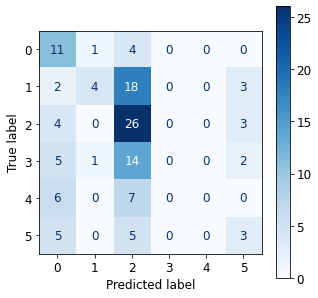

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(logit_model_best, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

### Extra Trees

In [ ]:
# ExtraTreesClassifier
# with scaled data - minmax
from sklearn.ensemble import ExtraTreesClassifier

ET = ExtraTreesClassifier(random_state=0).fit(X_train_trans, y_train)

y_pred_train = ET.predict(X_train_trans)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
et_prediction = ET.predict(X_test_trans)
b = mean_absolute_error(y_test, et_prediction)
print(b)
# score
print("Training Score:", ET.score(X_train_trans, y_train))
print("Testing Score:", ET.score(X_test_trans, y_test))
print(classification_report(y_test, et_prediction))

# Obtain F1-score
et_f1_score=f1_score(y_test, et_prediction, average='macro')
## examining sample skewness
et_test_skew=skew(et_prediction)
# ET error table 
et_error_table=pd.DataFrame({'Model':['Extra Trees (With scaler)'], 
                             'train error':[a],
                             'test error':[b], 
                             "train score":[ET.score(X_train_trans, y_train)], 
                             "test score":[ET.score(X_test_trans, y_test)], 
                             "F1-Score":[f1_score(y_test, et_prediction, average='macro')], 
                             "Skewness":[skew(et_prediction)],
                             "Kurtosis":[kurtosis(et_prediction)]})
et_error_table

train mae: 
0.0
test mae: 
0.5
Training Score: 1.0
Testing Score: 0.6209677419354839
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.73      0.89      0.80        27
           2       0.72      0.55      0.62        33
           3       0.48      0.45      0.47        22
           4       0.20      0.23      0.21        13
           5       0.43      0.46      0.44        13

    accuracy                           0.62       124
   macro avg       0.59      0.60      0.59       124
weighted avg       0.63      0.62      0.62       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Extra Trees (With scaler),0.0,0.5,1.0,0.620968,0.590756,0.335892,-0.967174


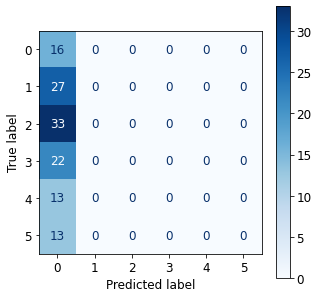

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(ET, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

### Gradient Boosting

In [ ]:
# Gradient boosting trees
# with scaled data - minmax
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(learning_rate = 0.01, random_state = 0)
gb_clf.fit(X_train_trans, y_train)

y_pred_train = gb_clf.predict(X_train_trans)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
gb_pred = gb_clf.predict(X_test_trans)
b = mean_absolute_error(y_test, gb_pred)
print(b)
# score
print("Training Score:", gb_clf.score(X_train_trans, y_train))
print("Testing Score:", gb_clf.score(X_test_trans, y_test))
print(classification_report(y_test, gb_pred))

# Obtain F1-score
gb_f1_score=f1_score(y_test, gb_pred, average='macro')
## examining sample skewness
gb_test_skew=skew(gb_pred)
# GB error table 
gb_error_table=pd.DataFrame({'Model':['Gradient Boosting (With scaler)'], 
                             'train error':[a],'test error':[b], 
                             "train score":[gb_clf.score(X_train_trans, y_train)], 
                             "test score":[gb_clf.score(X_test_trans, y_test)], 
                             "F1-Score":[f1_score(y_test, gb_pred, average='macro')], 
                             "Skewness":[skew(gb_pred)],
                             "Kurtosis":[kurtosis(gb_pred)]})
gb_error_table

train mae: 
0.3689516129032258
test mae: 
0.7096774193548387
Training Score: 0.7580645161290323
Testing Score: 0.532258064516129
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.65      0.56      0.60        27
           2       0.59      0.39      0.47        33
           3       0.34      0.45      0.39        22
           4       0.29      0.31      0.30        13
           5       0.40      0.62      0.48        13

    accuracy                           0.53       124
   macro avg       0.55      0.55      0.54       124
weighted avg       0.56      0.53      0.54       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Gradient Boosting (With scaler),0.368952,0.709677,0.758065,0.532258,0.541005,0.063895,-1.078464


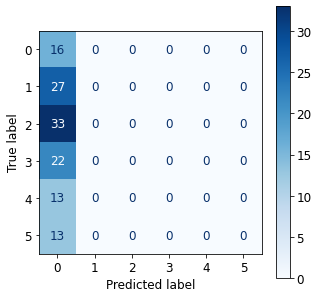

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(gb_clf, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

In [ ]:
# without scaler
# no difference
from sklearn.ensemble import GradientBoostingClassifier

gb_clf2 = GradientBoostingClassifier(learning_rate = 0.01, random_state = 0)
gb_clf2.fit(X_train, y_train)

y_pred_train = gb_clf2.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
gb_pred2 = clf.predict(X_test)
b = mean_absolute_error(y_test, gb_pred2)
print(b)
# score
print("Training Score:", gb_clf2.score(X_train, y_train))
print("Testing Score:", gb_clf2.score(X_test, y_test))
print(classification_report(y_test, gb_pred2))

# GB error table 
gb_error_table2=pd.DataFrame({'Model':['Gradient Boosting (Without scaler)'], 
                             'train error':[a],'test error':[b], 
                             "train score":[gb_clf2.score(X_train, y_train)], 
                             "test score":[gb_clf2.score(X_test, y_test)], 
                             "F1-Score":[f1_score(y_test, gb_pred2, average='macro')], 
                             "Skewness":[skew(gb_pred2)],
                             "Kurtosis":[kurtosis(gb_pred2)]})
gb_error_table2

train mae: 
0.3689516129032258
test mae: 
2.225806451612903
Training Score: 0.7580645161290323
Testing Score: 0.532258064516129
              precision    recall  f1-score   support

           0       0.13      1.00      0.23        16
           1       0.00      0.00      0.00        27
           2       0.00      0.00      0.00        33
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        13

    accuracy                           0.13       124
   macro avg       0.02      0.17      0.04       124
weighted avg       0.02      0.13      0.03       124



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Gradient Boosting (Without scaler),0.368952,2.225806,0.758065,0.532258,0.038095,0.0,-3.0


#### Feature Selection

In [ ]:
# with feature selection - ExtraTrees
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

gb_clf = GradientBoostingClassifier(learning_rate = 0.01, random_state = 0)
scaler = MinMaxScaler()
selector = SelectFromModel(ExtraTreesClassifier(n_estimators=50, random_state=0))

gb_pipe = Pipeline([('scaler',scaler), ('selector', selector), ('clf', gb_clf)])

gb_pipe.fit(X_train, y_train)
gb_pred = gb_pipe.predict(X_test)

y_pred_train = gb_pipe.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, gb_pred)
print(b)

# score
print("Training Score:", gb_pipe.score(X_train, y_train))
print("Testing Score:", gb_pipe.score(X_test, y_test))
print(classification_report(y_test, gb_pred))

# Obtain F1-score
gb_f1_score=f1_score(y_test, gb_pred, average='macro')
## examining sample skewness
gb_test_skew=skew(gb_pred)
# Random Forest error table 
gb_error_table3=pd.DataFrame({'Model':['Gradient Boosting (ExtraTrees)'], 
                             'train error':[a],'test error':[b], 
                             "train score":[gb_pipe.score(X_train, y_train)], 
                             "test score":[gb_pipe.score(X_test, y_test)], 
                             "F1-Score":[f1_score(y_test, gb_pred, average='macro')], 
                             "Skewness":[skew(gb_pred)],
                             "Kurtosis":[kurtosis(gb_pred)]})
gb_error_table3

train mae: 
0.41330645161290325
test mae: 
0.5645161290322581
Training Score: 0.7157258064516129
Testing Score: 0.6209677419354839
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.83      0.70      0.76        27
           2       0.60      0.55      0.57        33
           3       0.38      0.45      0.42        22
           4       0.42      0.38      0.40        13
           5       0.53      0.69      0.60        13

    accuracy                           0.62       124
   macro avg       0.63      0.63      0.62       124
weighted avg       0.64      0.62      0.63       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Gradient Boosting (ExtraTrees),0.413306,0.564516,0.715726,0.620968,0.624683,0.202851,-0.907105


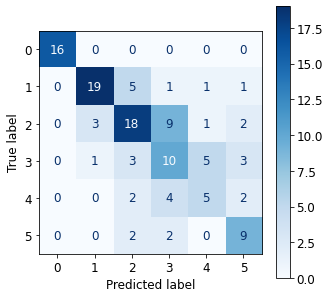

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(gb_pipe, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

In [ ]:
# with feature selection - SelectPercentile
from sklearn.feature_selection import SelectPercentile, chi2

gb_clf = GradientBoostingClassifier(learning_rate = 0.01, random_state = 0)
scaler = MinMaxScaler()
selector = SelectPercentile(chi2)

gb_pipe2 = Pipeline([('scaler',scaler), ('selector', selector), ('clf', gb_clf)])

gb_pipe2.fit(X_train, y_train)
gb_pred2 = gb_pipe2.predict(X_test)

y_pred_train2 = gb_pipe2.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train2)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, gb_pred2)
print(b)

# score
print("Training Score:", gb_pipe2.score(X_train, y_train))
print("Testing Score:", gb_pipe2.score(X_test, y_test))
print(classification_report(y_test, gb_pred2))

# Obtain F1-score
gb_f1_score=f1_score(y_test, gb_pred2, average='macro')
## examining sample skewness
gb_test_skew=skew(gb_pred2)
# Random Forest error table 
gb_error_table4=pd.DataFrame({'Model':['Gradient Boosting (SelectPercentile)'], 
                             'train error':[a],'test error':[b], 
                             "train score":[gb_pipe2.score(X_train, y_train)], 
                             "test score":[gb_pipe2.score(X_test, y_test)], 
                             "F1-Score":[f1_score(y_test, gb_pred2, average='macro')], 
                             "Skewness":[skew(gb_pred2)],
                             "Kurtosis":[kurtosis(gb_pred2)]})
gb_error_table4

train mae: 
0.4637096774193548
test mae: 
0.6451612903225806
Training Score: 0.6754032258064516
Testing Score: 0.5806451612903226
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.60      0.78      0.68        27
           2       0.53      0.27      0.36        33
           3       0.42      0.50      0.46        22
           4       0.46      0.46      0.46        13
           5       0.53      0.69      0.60        13

    accuracy                           0.58       124
   macro avg       0.59      0.62      0.59       124
weighted avg       0.58      0.58      0.56       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Gradient Boosting (SelectPercentile),0.46371,0.645161,0.675403,0.580645,0.592882,0.281983,-1.091585


#### Feature Expansion

In [ ]:
# feature expansion
gb_clf = GradientBoostingClassifier(learning_rate = 0.01, random_state = 0)
scaler = MinMaxScaler()
trans = PolynomialFeatures(2)

gb_pipe3 = Pipeline([('scaler',scaler), ('expansion', trans), ('clf', gb_clf)])

gb_pipe3.fit(X_train, y_train)
gb_pred3 = gb_pipe3.predict(X_test)

y_pred_train3 = gb_pipe3.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train3)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, gb_pred3)
print(b)

# score
print("Training Score:", gb_pipe3.score(X_train, y_train))
print("Testing Score:", gb_pipe3.score(X_test, y_test))
print(classification_report(y_test, gb_pred3))

# Obtain F1-score
gb_f1_score=f1_score(y_test, gb_pred3, average='macro')
## examining sample skewness
gb_test_skew=skew(gb_pred3)
# Random Forest error table 
gb_error_table5=pd.DataFrame({'Model':['Gradient Boosting (Expansion2)'], 
                             'train error':[a],'test error':[b], 
                             "train score":[gb_pipe3.score(X_train, y_train)], 
                             "test score":[gb_pipe3.score(X_test, y_test)], 
                             "F1-Score":[f1_score(y_test, gb_pred3, average='macro')], 
                             "Skewness":[skew(gb_pred3)],
                             "Kurtosis":[kurtosis(gb_pred3)]})
gb_error_table5

train mae: 
0.28830645161290325
test mae: 
0.75
Training Score: 0.8185483870967742
Testing Score: 0.5161290322580645
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.69      0.74      0.71        27
           2       0.65      0.33      0.44        33
           3       0.31      0.36      0.33        22
           4       0.14      0.15      0.15        13
           5       0.32      0.54      0.40        13

    accuracy                           0.52       124
   macro avg       0.52      0.52      0.51       124
weighted avg       0.55      0.52      0.52       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Gradient Boosting (Expansion2),0.288306,0.75,0.818548,0.516129,0.505961,0.12044,-1.217522


In [ ]:
# feature selection + feature expansion
gb_clf = GradientBoostingClassifier(learning_rate = 0.01, random_state = 0)
scaler = MinMaxScaler()
trans = PolynomialFeatures(2)
selector = SelectFromModel(ExtraTreesClassifier(n_estimators=50,random_state=0))

gb_pipe4 = Pipeline([('scaler',scaler), ('expansion', trans), ('selector',selector), ('clf', gb_clf)])

gb_pipe4.fit(X_train, y_train)
gb_pred4 = gb_pipe4.predict(X_test)

y_pred_train4 = gb_pipe4.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train4)
print(a)

print('test mae: ')
b = mean_absolute_error(y_test, gb_pred4)
print(b)

# score
print("Training Score:", gb_pipe4.score(X_train, y_train))
print("Testing Score:", gb_pipe4.score(X_test, y_test))
print(classification_report(y_test, gb_pred4))

# Obtain F1-score
gb_f1_score=f1_score(y_test, gb_pred4, average='macro')
## examining sample skewness
gb_test_skew=skew(gb_pred3)
# Random Forest error table 
gb_error_table6=pd.DataFrame({'Model':['Gradient Boosting (ExtraTrees + Expansion2)'], 
                             'train error':[a],'test error':[b], 
                             "train score":[gb_pipe4.score(X_train, y_train)], 
                             "test score":[gb_pipe4.score(X_test, y_test)], 
                             "F1-Score":[f1_score(y_test, gb_pred4, average='macro')], 
                             "Skewness":[skew(gb_pred4)],
                             "Kurtosis":[kurtosis(gb_pred4)]})
gb_error_table6

train mae: 
0.3810483870967742
test mae: 
0.8145161290322581
Training Score: 0.780241935483871
Testing Score: 0.5080645161290323
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.57      0.63      0.60        27
           2       0.60      0.36      0.45        33
           3       0.38      0.36      0.37        22
           4       0.21      0.31      0.25        13
           5       0.33      0.46      0.39        13

    accuracy                           0.51       124
   macro avg       0.52      0.52      0.51       124
weighted avg       0.54      0.51      0.51       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Gradient Boosting (ExtraTrees + Expansion2),0.381048,0.814516,0.780242,0.508065,0.509752,0.152213,-1.208829


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# default model
nb_clf = MultinomialNB()
scaler = MinMaxScaler() #there are negative values so use MinMax

nb_pipe = Pipeline([('scaler', scaler),('clf', nb_clf)])
nb_pipe.fit(X_train_trans, y_train)
y_pred_train = nb_pipe.predict(X_train_trans)
nb_prediction = nb_pipe.predict(X_test_trans)

In [ ]:

print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)
print('test mae: ')
b = mean_absolute_error(y_test, nb_prediction)
print(b)

# score
print("Training Score:", nb_pipe.score(X_train_trans, y_train))
print("Testing Score:", nb_pipe.score(X_test_trans, y_test))
print(classification_report(y_test, nb_prediction))

# Obtain F1-score
nb_f1_score=f1_score(y_test, nb_prediction, average='macro')
## examining sample skewness
nb_test_skew=skew(nb_prediction)
# NB error table 
nb_error_table=pd.DataFrame({'Model':['Naive Bayes (With scaler) - Baseline'], 
                             'train error':[a],'test error':[b], 
                             "train score":[nb_pipe.score(X_train_trans, y_train)], 
                             "test score":[nb_pipe.score(X_test_trans, y_test)], 
                             "F1-Score":[f1_score(y_test, nb_prediction, average='macro')], 
                             "Skewness":[skew(nb_prediction)],
                             "Kurtosis":[kurtosis(nb_prediction)]})
nb_error_table

train mae: 
1.3185483870967742
test mae: 
1.1774193548387097
Training Score: 0.3850806451612903
Testing Score: 0.3951612903225806
              precision    recall  f1-score   support

           0       0.50      0.75      0.60        16
           1       0.52      0.41      0.46        27
           2       0.34      0.70      0.46        33
           3       0.20      0.05      0.07        22
           4       0.40      0.15      0.22        13
           5       0.00      0.00      0.00        13

    accuracy                           0.40       124
   macro avg       0.33      0.34      0.30       124
weighted avg       0.35      0.40      0.34       124



,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Naive Bayes (With scaler) - Baseline,1.318548,1.177419,0.385081,0.395161,0.302438,0.380208,0.788192


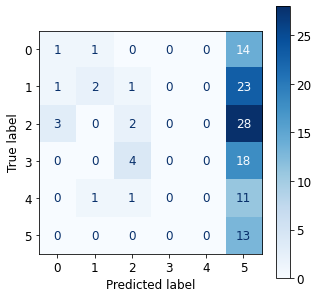

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
cm = plot_confusion_matrix(nb_pipe, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format="d")

### LDA Classification
Assuming each class is Gaussian and have constant variance

In [ ]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda=LinearDiscriminantAnalysis()
# fit lda on data
lda.fit(X_train_trans,y_train)
lda_train_pred=lda.predict(X_train_trans)
lda_test_pred=lda.predict(X_test_trans)
## training and testing errors
lda_train_error=np.mean(lda_train_pred != y_train)
lda_test_error= np.mean(lda_test_pred != y_test)
lda_train_score=lda.score(X_train_trans, y_train)
lda_test_score=lda.score(X_test_trans, y_test)

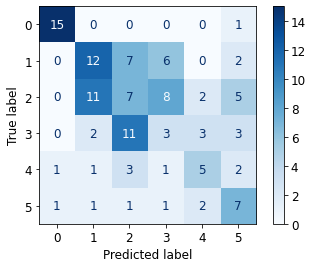

In [ ]:
# confusion matrix
from sklearn import metrics
metrics.plot_confusion_matrix(lda, X_test_trans, y_test, cmap=plt.cm.Blues)  

In [ ]:

lda_error_table=pd.DataFrame({'Model':['LDA (With scaler)'], 
                              'train error':[lda_train_error],
                              'test error':[lda_test_error], 
                              "train score":[lda_train_score], 
                              "test score":[lda_test_score], 
                              "F1-Score":[f1_score(y_test, lda_test_pred, average='macro')], 
                              "Skewness":[skew(lda_test_pred)],
                              "Kurtosis":[kurtosis(lda_test_pred)]})
lda_error_table


,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,LDA (With scaler),0.516129,0.604839,0.483871,0.395161,0.424988,0.289208,-1.044898


<i><font color=green> K-Fold-CV: </font><i>

In [ ]:
from numpy import mean
from numpy import std
## Evaluation- K-Fold Cross Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
lda_cv3= KFold(n_splits=3, random_state=0, shuffle=True)
lda_cv5= KFold(n_splits=5, random_state=0, shuffle=True)
lda_cv10 = KFold(n_splits=10, random_state=0, shuffle=True)
lda_scores3 = cross_val_score(lda, X, y, scoring='accuracy', cv=lda_cv3, n_jobs=-1)
lda_scores5 = cross_val_score(lda, X, y, scoring='accuracy', cv=lda_cv5, n_jobs=-1)
lda_scores10 = cross_val_score(lda, X, y, scoring='accuracy', cv=lda_cv10, n_jobs=-1)
print('3-Fold CV Accuracy: %.3f (%.3f)' % (mean(lda_scores3), std(lda_scores3)))
print('5-Fold CV Accuracy: %.3f (%.3f)' % (mean(lda_scores5), std(lda_scores5)))
print('10-Fold CV Accuracy: %.3f (%.3f)' % (mean(lda_scores10), std(lda_scores10)))

3-Fold CV Accuracy: 0.439 (0.014)
5-Fold CV Accuracy: 0.429 (0.027)
10-Fold CV Accuracy: 0.426 (0.047)


### QDA Classification
Assuming each class is Gaussian

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda=QuadraticDiscriminantAnalysis()
# fit lda on data
qda.fit(X_train_trans,y_train)
qda_train_pred=qda.predict(X_train_trans)
qda_test_pred=qda.predict(X_test_trans)
## training and testing errors
qda_train_error=np.mean(qda_train_pred != y_train)
qda_test_error= np.mean(qda_test_pred != y_test)
qda_train_score=qda.score(X_train_trans, y_train)
qda_test_score=qda.score(X_test_trans, y_test)

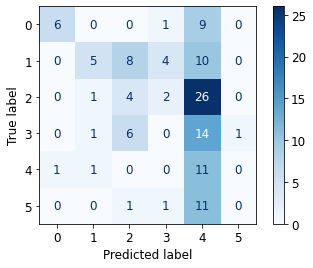

In [ ]:
# confusion matrix
metrics.plot_confusion_matrix(qda, X_test_trans, y_test, cmap=plt.cm.Blues)  

In [ ]:
# QDA error table 
qda_error_table=pd.DataFrame({'Model':['QDA (With scaler)'], 
                              'train error':[qda_train_error],
                              'test error':[qda_test_error], 
                              "train score":[qda_train_score], 
                              "test score":[qda_test_score], 
                              "F1-Score":[f1_score(y_test, qda_test_pred, average='macro')], 
                              "Skewness":[skew(qda_test_pred)],
                              "Kurtosis":[kurtosis(qda_test_pred)]})
qda_error_table

,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,QDA (With scaler),0.673387,0.790323,0.326613,0.209677,0.199224,-1.28805,0.411757


<i><font color=green> K-Fold-CV: </font><i>

In [ ]:
## Evaluation- K-Fold Cross Validation
qda_cv3= KFold(n_splits=3, random_state=0, shuffle=True)
qda_cv5= KFold(n_splits=5, random_state=0, shuffle=True)
qda_cv10 = KFold(n_splits=10, random_state=0, shuffle=True)
qda_scores3 = cross_val_score(qda, X, y, scoring='accuracy', cv=qda_cv3, n_jobs=-1)
qda_scores5 = cross_val_score(qda, X, y, scoring='accuracy', cv=qda_cv5, n_jobs=-1)
qda_scores10 = cross_val_score(qda, X, y, scoring='accuracy', cv=qda_cv10, n_jobs=-1)
print('3-Fold CV Accuracy: %.3f (%.3f)' % (mean(qda_scores3), std(qda_scores3)))
print('5-Fold CV Accuracy: %.3f (%.3f)' % (mean(qda_scores5), std(qda_scores5)))
print('10-Fold CV Accuracy: %.3f (%.3f)' % (mean(qda_scores10), std(qda_scores10)))

3-Fold CV Accuracy: 0.294 (0.039)
5-Fold CV Accuracy: 0.277 (0.042)
10-Fold CV Accuracy: 0.252 (0.055)


### Classification and Regression Trees (CART)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
dt_classifier = DecisionTreeClassifier(criterion="entropy")
dt_classifier.fit(X_train_trans,y_train)
#Predict the response for train dataset
dt_train_pred = dt_classifier.predict(X_train_trans)
#Predict the response for test dataset
dt_test_pred = dt_classifier.predict(X_test_trans)
dt_train_score=dt_classifier.score(X_train, y_train)
dt_test_score=dt_classifier.score(X_test, y_test)

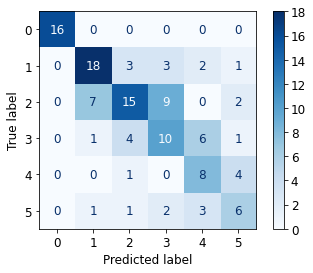

In [ ]:
# confusion matrix
metrics.plot_confusion_matrix(dt_classifier, X_test_trans, y_test, cmap=plt.cm.Blues)  

In [ ]:
# Decision Tree error table 
dt_error_table=pd.DataFrame({'Model':['CART (With scaler)'], 
                             'train error':[1-metrics.accuracy_score(y_train, dt_train_pred)],
                             'test error':[1-metrics.accuracy_score(y_test, dt_test_pred)], 
                             "train score":[dt_train_score], 
                             "test score":[dt_test_score], 
                             "F1-Score":[f1_score(y_test, dt_test_pred, average='macro')], 
                             "Skewness":[skew(dt_test_pred)],
                              "Kurtosis":[kurtosis(dt_test_pred)]})
dt_error_table

,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,CART (With scaler),0.0,0.41129,0.16129,0.129032,0.595368,0.140396,-1.066185


<i><font color=green> K-Fold-CV: </font><i>

In [ ]:
## Evaluation- K-Fold Cross Validation
dt_cv3= KFold(n_splits=3, random_state=0, shuffle=True)
dt_cv5= KFold(n_splits=5, random_state=0, shuffle=True)
dt_cv10 = KFold(n_splits=10, random_state=0, shuffle=True)
dt_scores3 = cross_val_score(dt_classifier, X, y, scoring='accuracy', cv=dt_cv3, n_jobs=-1)
dt_scores5 = cross_val_score(dt_classifier, X, y, scoring='accuracy', cv=dt_cv5, n_jobs=-1)
dt_scores10 = cross_val_score(dt_classifier, X, y, scoring='accuracy', cv=dt_cv10, n_jobs=-1)
print('3-Fold CV Accuracy: %.3f (%.3f)' % (mean(dt_scores3), std(dt_scores3)))
print('5-Fold CV Accuracy: %.3f (%.3f)' % (mean(dt_scores5), std(dt_scores5)))
print('10-Fold CV Accuracy: %.3f (%.3f)' % (mean(dt_scores10), std(dt_scores10)))

3-Fold CV Accuracy: 0.519 (0.021)
5-Fold CV Accuracy: 0.577 (0.041)
10-Fold CV Accuracy: 0.539 (0.056)


### Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
# define the model
bagging_classifier = BaggingClassifier()
# fit the model on the whole dataset
bagging_classifier.fit(X_train_trans, y_train)
#Predict the response for train dataset
bagging_train_pred=bagging_classifier.predict(X_train_trans)
#Predict the response for test dataset
bagging_test_pred=bagging_classifier.predict(X_test_trans)
bagging_train_score=bagging_classifier.score(X_train_trans, y_train)
bagging_test_score=bagging_classifier.score(X_test_trans, y_test)

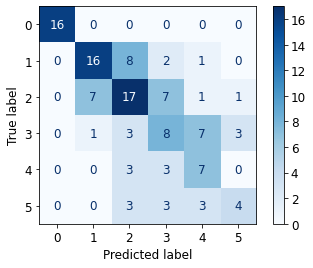

In [ ]:
# confusion matrix
metrics.plot_confusion_matrix(bagging_classifier, X_test_trans, y_test,cmap=plt.cm.Blues)  

In [ ]:
# Bagging error table 
bagging_error_table=pd.DataFrame({'Model':['Bagging (With scaler)'], 
                                  'train error':[1-metrics.accuracy_score(y_train, bagging_train_pred)],
                                  'test error':[1-metrics.accuracy_score(y_test, bagging_test_pred)], 
                                  "train score":[bagging_train_score], 
                                  "test score":[bagging_test_score], 
                                  "F1-Score":[f1_score(y_test, bagging_test_pred, average='macro')], 
                                  "Skewness":[skew(bagging_test_pred)],
                                  "Kurtosis":[kurtosis(bagging_test_pred)]})
bagging_error_table

,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,Bagging (With scaler),0.022177,0.451613,0.977823,0.548387,0.551487,0.168065,-0.82598


<i><font color=green> K-Fold-CV: </font><i>

In [ ]:
## Evaluation- K-Fold Cross Validation
bagging_cv3= KFold(n_splits=3, random_state=0, shuffle=True)
bagging_cv5= KFold(n_splits=5, random_state=0, shuffle=True)
bagging_cv10 = KFold(n_splits=10, random_state=0, shuffle=True)
bagging_scores3 = cross_val_score(bagging_classifier, X, y, scoring='accuracy', cv=bagging_cv3, n_jobs=-1)
bagging_scores5 = cross_val_score(bagging_classifier, X, y, scoring='accuracy', cv=bagging_cv5, n_jobs=-1)
bagging_scores10 = cross_val_score(bagging_classifier, X, y, scoring='accuracy', cv=bagging_cv10, n_jobs=-1)
print('3-Fold CV Accuracy: %.3f (%.3f)' % (mean(bagging_scores3), std(bagging_scores3)))
print('5-Fold CV Accuracy: %.3f (%.3f)' % (mean(bagging_scores5), std(bagging_scores5)))
print('10-Fold CV Accuracy: %.3f (%.3f)' % (mean(bagging_scores10), std(bagging_scores10)))

3-Fold CV Accuracy: 0.564 (0.025)
5-Fold CV Accuracy: 0.558 (0.021)
10-Fold CV Accuracy: 0.573 (0.067)


### Boosting (AdaBoost)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# define the model
boosting_classifier = AdaBoostClassifier()
# fit the model on the whole dataset
boosting_classifier.fit(X_train_trans, y_train)
#Predict the response for train dataset
boosting_train_pred=boosting_classifier.predict(X_train_trans)
#Predict the response for test dataset
boosting_test_pred=boosting_classifier.predict(X_test_trans)
## training and testing errors
boosting_train_error=np.mean(boosting_train_pred!=y_train)
boosting_test_error= np.mean(boosting_test_pred != y_test)
boosting_train_score=boosting_classifier.score(X_train_trans, y_train)
boosting_test_score=boosting_classifier.score(X_test_trans, y_test)

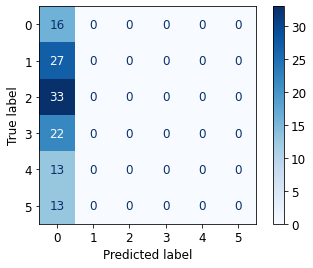

In [ ]:
# confusion matrix
metrics.plot_confusion_matrix(boosting_classifier, X_test, y_test, cmap=plt.cm.Blues)  

In [ ]:
# Boosting error table 
boosting_error_table=pd.DataFrame({'Model':['AdaBoost (With scaler)'], 
                                   'train error':[boosting_train_error],
                                   'test error':[boosting_test_error], 
                                   "train score":[boosting_train_score], 
                                   "test score":[boosting_test_score], 
                                   "F1-Score":[f1_score(y_test, boosting_test_pred, average='macro')], 
                                   "Skewness":[skew(boosting_test_pred)],
                                   "Kurtosis":[kurtosis(boosting_test_pred)]})
boosting_error_table

,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,AdaBoost (With scaler),0.524194,0.596774,0.475806,0.403226,0.369157,0.417929,-0.412642


<i><font color=green> K-Fold-CV: </font><i>

In [ ]:

## Evaluation- K-Fold Cross Validation
boosting_cv3= KFold(n_splits=3, random_state=0, shuffle=True)
boosting_cv5= KFold(n_splits=5, random_state=0, shuffle=True)
boosting_cv10 = KFold(n_splits=10, random_state=0, shuffle=True)
boosting_scores3 = cross_val_score(boosting_classifier, X, y, scoring='accuracy', cv=boosting_cv3, n_jobs=-1)
boosting_scores5 = cross_val_score(boosting_classifier, X, y, scoring='accuracy', cv=boosting_cv5, n_jobs=-1)
boosting_scores10 = cross_val_score(boosting_classifier, X, y, scoring='accuracy', cv=boosting_cv10, n_jobs=-1)
print('3-Fold CV Accuracy: %.3f (%.3f)' % (mean(boosting_scores3), std(boosting_scores3)))
print('5-Fold CV Accuracy: %.3f (%.3f)' % (mean(boosting_scores5), std(boosting_scores5)))
print('10-Fold CV Accuracy: %.3f (%.3f)' % (mean(boosting_scores10), std(boosting_scores10)))

3-Fold CV Accuracy: 0.408 (0.015)
5-Fold CV Accuracy: 0.400 (0.025)
10-Fold CV Accuracy: 0.379 (0.082)


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# define the model
knn = KNeighborsClassifier(n_neighbors=7)
# fit the model on the whole dataset
knn.fit(X_train_trans, y_train)
#Predict the response for train dataset
knn_train_pred=knn.predict(X_train_trans)
#Predict the response for test dataset
knn_test_pred=knn.predict(X_test_trans)
## training and testing errors
knn_train_error=np.mean(knn_train_pred!=y_train)
knn_test_error= np.mean(knn_test_pred != y_test)
knn_train_score=knn.score(X_train_trans, y_train)
knn_test_score=knn.score(X_test_trans, y_test)

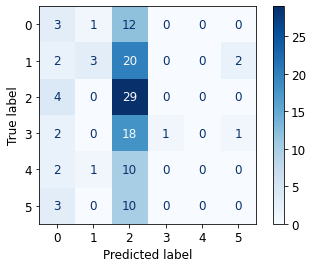

In [ ]:
# confusion matrix
plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)  

In [ ]:
# KNN error table 
knn_error_table=pd.DataFrame({'Model':['KNN (K=7)'], 
                              'train error':[knn_train_error],
                              'test error':[knn_test_error], 
                              "train score":[knn_train_score], 
                              "test score":[knn_test_score], 
                              "F1-Score":[f1_score(y_test, knn_test_pred, average='macro')], 
                              "Skewness":[skew(knn_test_pred)],
                              "Kurtosis":[kurtosis(knn_test_pred)]})
knn_error_table

,Model,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
0,KNN (K=7),0.417339,0.540323,0.582661,0.459677,0.431001,0.639962,-0.020552


<i><font color=green> K-Fold-CV: </font><i>

In [ ]:
## Evaluation- K-Fold Cross Validation
knn_cv3= KFold(n_splits=3, random_state=0, shuffle=True)
knn_cv5= KFold(n_splits=5, random_state=0, shuffle=True)
knn_cv10 = KFold(n_splits=10, random_state=0, shuffle=True)
knn_scores3 = cross_val_score(knn, X, y, scoring='accuracy', cv=knn_cv3, n_jobs=-1)
knn_scores5 = cross_val_score(knn, X, y, scoring='accuracy', cv=knn_cv5, n_jobs=-1)
knn_scores10 = cross_val_score(knn, X, y, scoring='accuracy', cv=knn_cv10, n_jobs=-1)
print('3-Fold CV Accuracy: %.3f (%.3f)' % (mean(knn_scores3), std(knn_scores3)))
print('5-Fold CV Accuracy: %.3f (%.3f)' % (mean(knn_scores5), std(knn_scores5)))
print('10-Fold CV Accuracy: %.3f (%.3f)' % (mean(knn_scores10), std(knn_scores10)))

3-Fold CV Accuracy: 0.281 (0.040)
5-Fold CV Accuracy: 0.276 (0.051)
10-Fold CV Accuracy: 0.289 (0.040)


### Summary Table 

In [ ]:
model_summary=pd.concat([svc_error_table, svc_error_table2, svc_error_table3,
                         mlp_error_table, mlp_error_table2, mlp_error_table3, mlp_error_table4, mlp_error_table5, mlp_error_table6,
                         rf_error_table, rf_error_table2, rf_error_table3, rf_error_table4, rf_error_table5, rf_error_table6,
                         logit_error_table, 
                         et_error_table, 
                         gb_error_table, gb_error_table2, gb_error_table3, gb_error_table4, gb_error_table5, gb_error_table6, 
                         nb_error_table, 
                         lda_error_table,
                         qda_error_table,
                         dt_error_table,
                         bagging_error_table,
                         boosting_error_table,
                         knn_error_table])
model_summary.set_index('Model',inplace=True)
#model_summary.sort_values(["F1-Score", "test error"], ascending = (False, True))
pd.options.display.float_format = '{:.3f}'.format
model_summary

,train error,test error,train score,test score,F1-Score,Skewness,Kurtosis
Model,,,,,,,
SVC (With scaler) - Baseline,0.639,0.742,0.605,0.492,0.498,0.482,-0.873
SVC (Without scaler),1.383,1.161,0.214,0.282,0.094,-7.682,57.016
SVC (ExtraTrees),0.833,0.847,0.510,0.524,0.503,0.542,-1.006
MLP (With scaler),0.335,0.710,0.778,0.508,0.515,0.537,-0.469
MLP (Without scaler),1.498,1.250,0.397,0.411,0.115,-2.647,5.202
MLP (SelectPercentile),0.921,0.927,0.492,0.452,0.427,0.104,-1.308
MLP (ExtraTrees),0.708,0.758,0.556,0.532,0.503,0.365,-1.003
MLP (Expansion2),0.034,0.694,0.978,0.516,0.510,0.454,-0.890
MLP (ExtraTrees + Expansion2),0.361,0.661,0.742,0.573,0.558,0.358,-0.880


# Using only Billboard tweets + Billboard data (without Spotify class)

In [ ]:
## keep Billboard data

billboard = pd.merge( df,A, how='left', on=['week', 'song','artist'],indicator=True) # Note
# billboard = billboard[billboard['_merge']=='both']
cols = ['week','song','artist','url_avg','et_url_avg','display_url_avg','hashtag_avg','et_hashtag_avg',
'avg_followers','avg_friends','avg_listed','sum_trunc','sum_http','avg_tokens','avg_char',
'avg_senti','avg_emoji_count','rank_last_week','peak_rank','weeks_on_chart','tweets_count','rank']
billboard=billboard.filter(cols)
billboard = billboard.fillna(0)

In [ ]:
# dataset
# factorize
billboard['song_id'],song_name = pd.factorize(billboard['song'])
billboard['artist_id'],song_name = pd.factorize(billboard['artist'])

# classification: 5 classes
cut_labels_5 = [0,1, 2, 3, 4,5]
cut_bins = [-1,0, 20, 40, 60, 80, 100]
billboard['pop'] = pd.cut(billboard['rank'], bins=cut_bins, labels=cut_labels_5)

y = billboard['pop']
X = billboard.drop(columns=['pop','song','artist','rank'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# SVC
from sklearn.svm import SVC

svc = SVC(random_state=0, tol=1e-5, max_iter=200000)
svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
prediction = svc.predict(X_test)
b = mean_absolute_error(y_test, prediction)
print(b)

# score
print("Training Score:", svc.score(X_train, y_train))
print("Testing Score:", svc.score(X_test, y_test))
print(classification_report(y_test, prediction))

train mae: 
0.3423076923076923
test mae: 
0.35
Training Score: 0.6923076923076923
Testing Score: 0.6807692307692308
              precision    recall  f1-score   support

           1       0.84      0.93      0.89        46
           2       0.71      0.76      0.73        62
           3       0.65      0.46      0.54        56
           4       0.49      0.64      0.55        44
           5       0.72      0.63      0.67        52

    accuracy                           0.68       260
   macro avg       0.68      0.69      0.68       260
weighted avg       0.69      0.68      0.68       260



In [ ]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier

reg = RandomForestClassifier(random_state=0).fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
prediction = reg.predict(X_test)
b = mean_absolute_error(y_test, prediction)
print(b)
# print(prediction)
# score
print("Training Score:", reg.score(X_train, y_train))
print("Testing Score:", reg.score(X_test, y_test))
print(classification_report(y_test, prediction))

train mae: 
0.0
test mae: 
0.27692307692307694
Training Score: 1.0
Testing Score: 0.7423076923076923
              precision    recall  f1-score   support

           1       0.88      0.93      0.91        46
           2       0.78      0.81      0.79        62
           3       0.70      0.62      0.66        56
           4       0.59      0.61      0.60        44
           5       0.75      0.73      0.74        52

    accuracy                           0.74       260
   macro avg       0.74      0.74      0.74       260
weighted avg       0.74      0.74      0.74       260



In [ ]:
# ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

ET = ExtraTreesClassifier(random_state=0).fit(X_train, y_train)

y_pred_train = ET.predict(X_train)
print('train mae: ')
a = mean_absolute_error(y_train,y_pred_train)
print(a)

print('test mae: ')
prediction = ET.predict(X_test)
b = mean_absolute_error(y_test, prediction)
print(b)
# score
print("Training Score:", ET.score(X_train, y_train))
print("Testing Score:", ET.score(X_test, y_test))
print(classification_report(y_test, prediction))

train mae: 
0.0
test mae: 
0.3269230769230769
Training Score: 1.0
Testing Score: 0.7115384615384616
              precision    recall  f1-score   support

           1       0.91      0.91      0.91        46
           2       0.76      0.76      0.76        62
           3       0.68      0.54      0.60        56
           4       0.51      0.68      0.58        44
           5       0.73      0.69      0.71        52

    accuracy                           0.71       260
   macro avg       0.72      0.72      0.71       260
weighted avg       0.72      0.71      0.71       260



# Predict ranks (terrible...)

In [ ]:
# dataset

y = billboard['rank']
X = billboard.drop(columns=['pop','song','artist','rank'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)

prediction_train = lr.predict(X_train)
print('train mse: ',mean_squared_error(y_train, prediction_train))

prediction = lr.predict(X_test)
print('test mse: ',mean_squared_error(y_test, prediction))

train mse:  243.00391750563594
test mse:  209.75464717374047


In [ ]:
# SGDRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


sgd = SGDRegressor(random_state=0, tol=1e-5, max_iter=10000)
sgd.fit(X_train, y_train)

y_pred_train = sgd.predict(X_train)
print('train mse: ')
a = mean_squared_error(y_train,y_pred_train)
print(a)

print('test mse: ')
prediction = sgd.predict(X_test)
b = mean_squared_error(y_test, prediction)
print(b)

train mse: 
247.52967378999514
test mse: 
214.74522660089332
